<a href="https://colab.research.google.com/github/Nganle21/Amazon_Waffeleisen/blob/main/MA_SP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m spacy download en_core_web_lg
!pip install category_encoders
!pip install sklearn_crfsuite
!pip install -U 'scikit-learn<0.24'
!pip install transformers
!pip install vaderSentiment
!pip install bert-for-tf2

Use first created file train and test from Jedox

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import operator
import math
import spacy
import scipy
from tqdm import tqdm
nlp = spacy.load('en_core_web_lg')
from sklearn.model_selection import train_test_split
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.util import ngrams
n_gram = 1
from nltk.tokenize.treebank import TreebankWordDetokenizer
kfold=10
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, f1_score, recall_score, precision_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt 
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import WhitespaceTokenizer
import category_encoders as ce

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding, Dense, TimeDistributed, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Activation, SpatialDropout1D, Bidirectional, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import load_model
from tensorflow import keras


import keras as k
import keras.backend as K

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

import transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from bert.model import BertModelLayer
from bert.loader import params_from_pretrained_ckpt, load_stock_weights

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Split Train Test

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/admin.xlsx",engine="openpyxl")
#df.head()
train, test = train_test_split(df, test_size=0.3, random_state = 29)
#train.to_excel("/content/drive/MyDrive/Colab Notebooks/absa_train.xlsx")
#test.to_excel("/content/drive/MyDrive/Colab Notebooks/absa_test.xlsx")



# Data Preprocessing

In [ ]:
#train = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/train_final.xlsx",engine="openpyxl")
#test = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/test_final.xlsx",engine="openpyxl")

In [ ]:
train_sp = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/train.xlsx",engine="openpyxl")
test_sp = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/test.xlsx",engine="openpyxl")

/usr/local/lib/python3.8/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
test_sp

,id,text,aspectTerm,From,To,SP
0,142090,Perfect. Waffles succeed straight away. Gladly...,Waffles,9,16,positive
1,142096,"The waffles are not evenly browned, unfortunat...",waffles,4,11,negative
2,142096,"The waffles are not evenly browned, unfortunat...",regulation of the temperature,62,91,negative
3,142096,"The waffles are not evenly browned, unfortunat...",use,111,114,neutral
4,142096,"The waffles are not evenly browned, unfortunat...",use,137,140,neutral
...,...,...,...,...,...,...
462,145346,It is very simple to handle and the price qual...,coating,81,88,positive
463,145357,"Easy to clean, heat enough and the materials s...",clean,8,13,positive
464,145357,"Easy to clean, heat enough and the materials s...",heat,15,19,positive
465,145357,"Easy to clean, heat enough and the materials s...",materials,35,44,positive


##Data Exploration + Feature Selection SP

### Feature Selection

#### Create COC

In [ ]:
train_sp

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids"
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f..."
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six."
...,...,...,...,...,...,...,...,...
1083,145299,When I used the machine to make triangular san...,bakes,106,111,positive,"machine triangular sandwiches, handle broke. d...","sandwiches, handle broke. device good, well."
1084,145303,The device is very bad in terms of price,price,35,40,negative,device bad terms price,device bad terms
1085,145309,Its size is small than I expected.,size,4,8,negative,size small expected.,small expected.
1086,145316,The products come out delicious.,products,4,12,positive,products come delicious.,come delicious.


In [ ]:
#remove stopwords
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words

def stop_word(string):
  lst=[]
  for token in string.split():
      if token.lower() not in stopwords:    #checking whether the word is not 
          lst.append(token.lower()) 
  return ' '.join(lst)

#create word COC
def word_coc(s, aspect):
    window_size = 5
    before_keyword, keyword, after_keyword = s.partition(aspect)
    if (len(before_keyword.split()) <= window_size):
      b = before_keyword.split()[0:len(before_keyword.split())]
    else:
      b = before_keyword.split()[(len(before_keyword.split())-window_size):len(before_keyword.split())]
    a = after_keyword.split()[0:window_size]
    ba = TreebankWordDetokenizer().detokenize(b+a)
    return ba


train_sp['text_wo_sw'] = train_sp['text'].apply(lambda x: stop_word(x))
test_sp['text_wo_sw'] = test_sp['text'].apply(lambda x: stop_word(x))
train_sp['coc'] = train_sp.apply(lambda x: word_coc(x.text_wo_sw, x.aspectTerm), axis=1)
test_sp['coc'] = test_sp.apply(lambda x: word_coc(x.text_wo_sw, x.aspectTerm), axis=1)

In [ ]:
train_sp


,id,text,aspectTerm,From,To,SP,text_wo_sw,coc
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids"
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f..."
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six."
...,...,...,...,...,...,...,...,...
1083,145299,When I used the machine to make triangular san...,bakes,106,111,positive,"machine triangular sandwiches, handle broke. d...","sandwiches, handle broke. device good, well."
1084,145303,The device is very bad in terms of price,price,35,40,negative,device bad terms price,device bad terms
1085,145309,Its size is small than I expected.,size,4,8,negative,size small expected.,small expected.
1086,145316,The products come out delicious.,products,4,12,positive,products come delicious.,come delicious.


#### Vectorization

Declare feature vector and target variable

In [ ]:


vectorizer = TfidfVectorizer(max_df=0.95)

# Create the training set with the words encoded as features of the reviews
X_train = vectorizer.fit_transform(train_sp['coc'])
X_test = vectorizer.transform(test_sp['coc'])
y_train = train_sp['SP']
y_test = test_sp['SP']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1088, 1396) (1088,) (467, 1396) (467,)


In [ ]:
train_sp['SP'].value_counts()/train_sp.shape[0]

positive    0.588235
negative    0.317096
neutral     0.094669
Name: SP, dtype: float64

# SP

## Lexicon-based

### VADER

In [ ]:
vader = SentimentIntensityAnalyzer()
lbm_data = train_sp.append(test_sp, ignore_index=True)
lbm_data['scores'] = lbm_data['coc'].apply(lambda coc: vader.polarity_scores(coc))
lbm_data['compound']  = lbm_data['scores'].apply(lambda score_dict: score_dict['compound'])

pos = []
for i in range(len(lbm_data)):
        if (lbm_data['SP'][i])=="positive":
            pos.append('1')
        elif (lbm_data['SP'][i])=="negative":
            pos.append('-1')
        else:
            pos.append('0')
lbm_data['true'] = pos
lbm_data.head()

pred = []
for i in range(len(lbm_data)):
        if (lbm_data['compound'][i])>0:
            pred.append('1')
        elif (lbm_data['compound'][i])<0:
            pred.append('-1')
        else:
            pred.append('0')
lbm_data['pred'] = pred
lbm_data.head()

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc,scores,compound,true,pred
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1,0
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids","{'neg': 0.625, 'neu': 0.375, 'pos': 0.0, 'comp...",-0.6124,-1,-1
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f...","{'neg': 0.485, 'neu': 0.515, 'pos': 0.0, 'comp...",-0.6808,-1,-1
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,0
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six.","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,0


In [ ]:
print('accuracy')
print(accuracy_score(lbm_data.true, lbm_data.pred))
print('f1 score')
print(f1_score(lbm_data.true, lbm_data.pred,average='weighted'))
print('recall')
print(recall_score(lbm_data.true, lbm_data.pred,average='weighted'))
print('precision')
print(precision_score(lbm_data.true, lbm_data.pred,average='weighted'))

accuracy
0.6881028938906752
f1 score
0.6772254874921957
recall
0.6881028938906752
precision
0.7219257067193191


In [ ]:
print(classification_report(lbm_data.true, lbm_data.pred))

              precision    recall  f1-score   support

          -1       0.83      0.40      0.54       475
           0       0.15      0.21      0.18       138
           1       0.75      0.90      0.82       942

    accuracy                           0.69      1555
   macro avg       0.58      0.50      0.51      1555
weighted avg       0.72      0.69      0.68      1555



### TextBlob

In [ ]:
#Create a function to get the polarity
def getPolarity(text):
   return TextBlob(text).sentiment.polarity

In [ ]:
lbm_data['polarity'] = lbm_data['coc'].apply(lambda coc: getPolarity(coc))
pred = []
for i in range(len(lbm_data)):
        if (lbm_data['polarity'][i])>0:
            pred.append('1')
        elif (lbm_data['polarity'][i])<0:
            pred.append('-1')
        else:
            pred.append('0')
lbm_data['pred'] = pred
lbm_data.head()

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc,scores,compound,true,pred,pos_tags,senti_score,polarity
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1,0,"[(satisfied, JJ), (..., :), (device, NN), (tim...",0.875,0.000
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids","{'neg': 0.625, 'neu': 0.375, 'pos': 0.0, 'comp...",-0.6124,-1,1,"[(cheap, RB), (,, ,), (wobbling, VBG), (unstab...",-0.250,0.400
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f...","{'neg': 0.485, 'neu': 0.515, 'pos': 0.0, 'comp...",-0.6808,-1,1,"[(cheap, JJ), (processing, NN), (,, ,), (wobbl...",-1.000,0.325
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,1,"[(independently, RB), (time, NN), (open, JJ), ...",-0.750,0.225
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six.","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,-1,"[(iron, NN), (remain, NN), (,, ,), (small, JJ)...",-0.375,-0.250


In [ ]:
print('accuracy')
print(accuracy_score(lbm_data.true, lbm_data.pred))
print('f1 score')
print(f1_score(lbm_data.true, lbm_data.pred,average='weighted'))
print('recall')
print(recall_score(lbm_data.true, lbm_data.pred,average='weighted'))
print('precision')
print(precision_score(lbm_data.true, lbm_data.pred,average='weighted'))

accuracy
0.7080385852090032
f1 score
0.694932448305261
recall
0.7080385852090032
precision
0.7308192244540054


In [ ]:
print(classification_report(lbm_data.true, lbm_data.pred))

              precision    recall  f1-score   support

          -1       0.85      0.44      0.58       475
           0       0.17      0.20      0.18       138
           1       0.76      0.92      0.83       942

    accuracy                           0.71      1555
   macro avg       0.59      0.52      0.53      1555
weighted avg       0.73      0.71      0.69      1555



In [ ]:
lbm_data

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc,scores,compound,true,pred,pos_tags,senti_score,polarity
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1,0,"[(satisfied, JJ), (..., :), (device, NN), (tim...",0.875,0.000000
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids","{'neg': 0.625, 'neu': 0.375, 'pos': 0.0, 'comp...",-0.6124,-1,1,"[(cheap, RB), (,, ,), (wobbling, VBG), (unstab...",-0.250,0.400000
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f...","{'neg': 0.485, 'neu': 0.515, 'pos': 0.0, 'comp...",-0.6808,-1,1,"[(cheap, JJ), (processing, NN), (,, ,), (wobbl...",-1.000,0.325000
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,1,"[(independently, RB), (time, NN), (open, JJ), ...",-0.750,0.225000
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six.","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,-1,"[(iron, NN), (remain, NN), (,, ,), (small, JJ)...",-0.375,-0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550,145346,It is very simple to handle and the price qual...,coating,81,88,positive,simple handle price quality relationship good....,handle price quality relationship good. non -s...,"{'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'comp...",0.4404,1,1,"[(handle, JJ), (price, NN), (quality, NN), (re...",1.125,0.700000
1551,145357,"Easy to clean, heat enough and the materials s...",clean,8,13,positive,"easy clean, heat materials good quality plasti...","easy, heat materials good quality","{'neg': 0.0, 'neu': 0.341, 'pos': 0.659, 'comp...",0.7003,1,1,"[(easy, JJ), (,, ,), (heat, JJ), (materials, N...",1.500,0.566667
1552,145357,"Easy to clean, heat enough and the materials s...",heat,15,19,positive,"easy clean, heat materials good quality plasti...","easy clean, materials good quality plasticucho...","{'neg': 0.0, 'neu': 0.208, 'pos': 0.792, 'comp...",0.8860,1,1,"[(easy, JJ), (clean, JJ), (,, ,), (materials, ...",2.375,0.550000
1553,145357,"Easy to clean, heat enough and the materials s...",materials,35,44,positive,"easy clean, heat materials good quality plasti...","easy clean, heat good quality plasticuchos. go...","{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...",0.8860,1,1,"[(easy, JJ), (clean, NN), (,, ,), (heat, NN), ...",2.250,0.550000


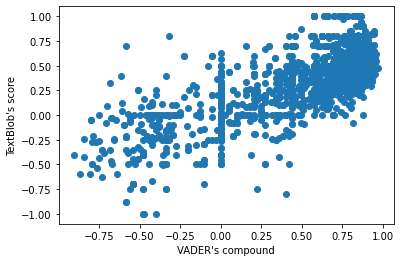

In [ ]:
from matplotlib import pyplot as plt
plt.scatter(lbm_data.compound, lbm_data.polarity)
plt.xlabel("VADER's compound")
plt.ylabel("TextBlob's score")
plt.show()

[Text(0, 0.5, 'SentiWordNet Scores'), Text(0.5, 0, 'TextBlob Scores')]

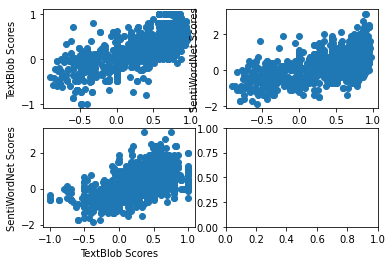

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(lbm_data.compound, lbm_data.polarity)
axs[0, 0].set(xlabel='VADER Compounds', ylabel='TextBlob Scores')
axs[0, 1].scatter(lbm_data.compound, lbm_data.senti_score)
axs[0, 1].set(xlabel='VADER Compounds', ylabel='SentiWordNet Scores')
axs[1, 0].scatter(lbm_data.polarity, lbm_data.senti_score)
axs[1, 0].set(xlabel='TextBlob Scores', ylabel='SentiWordNet Scores')

### SentiWordNet

In [ ]:
lemmatizer = WordNetLemmatizer()
def Lemmatization(data,name):
    def getting2(sen):
        
        example = sen
        output_sentence =[]
        word_tokens2 = word_tokenize(example)
        lemmatized_output = [lemmatizer.lemmatize(w) for w in word_tokens2]
        
        # Remove characters which have length less than 2  
        without_single_chr = [word for word in lemmatized_output if len(word) > 2]
        # Remove numbers
        cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]
        
        return cleaned_data_title
    # Using "getting2(sen)" function to append edited sentence to data
    x=[]
    for i in data[name].values:
        x.append(getting2(i))
    data[name]=x

In [ ]:
from nltk.tokenize import word_tokenize 
pos=neg=obj=count=0

postagging = []

for review in lbm_data['coc']:
    list = word_tokenize(review)
    postagging.append(nltk.pos_tag(list))

lbm_data['pos_tags'] = postagging

def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


# Returns list of pos-neg and objective score. But returns empty list if not present in senti wordnet.
def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    #Lemmatization
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    #Synset is a special kind of a simple interface that is present in NLTK to look up words in WordNet. 
    #Synset instances are the groupings of synonymous words that express the same concept. 
    #Some of the words have only one Synset and some have several.
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    pos=neg=obj=count=0
    
    ###################################################################################
senti_score = []

for pos_val in lbm_data['pos_tags']:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  #positive score is stored at 2nd position
            neg = neg + score[2]  #negative score is stored at 3rd position
        except:
            continue
    senti_score.append(pos - neg)
    pos=neg=0    
    
lbm_data['senti_score'] = senti_score
#print(lbm_data['senti_score'])

lbm_data.head()

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc,scores,compound,true,pred,pos_tags,senti_score,polarity
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1,0,"[(satisfied, JJ), (..., :), (device, NN), (tim...",0.875,0.000
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids","{'neg': 0.625, 'neu': 0.375, 'pos': 0.0, 'comp...",-0.6124,-1,1,"[(cheap, RB), (,, ,), (wobbling, VBG), (unstab...",-0.250,0.400
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f...","{'neg': 0.485, 'neu': 0.515, 'pos': 0.0, 'comp...",-0.6808,-1,1,"[(cheap, JJ), (processing, NN), (,, ,), (wobbl...",-1.000,0.325
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,1,"[(independently, RB), (time, NN), (open, JJ), ...",-0.750,0.225
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six.","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-1,-1,"[(iron, NN), (remain, NN), (,, ,), (small, JJ)...",-0.375,-0.250


In [ ]:
pred = []
for i in range(len(lbm_data)):
        if (lbm_data['senti_score'][i])>=0.05:
            pred.append('1')
        elif (lbm_data['senti_score'][i])<= -0.05:
            pred.append('-1')
        else:
            pred.append('0')
lbm_data['pred'] = pred

In [ ]:
print('accuracy')
print(accuracy_score(lbm_data.true, lbm_data.pred))
print('f1 score')
print(f1_score(lbm_data.true, lbm_data.pred,average='macro'))
print('recall')
print(recall_score(lbm_data.true, lbm_data.pred,average='macro'))
print('precision')
print(precision_score(lbm_data.true, lbm_data.pred,average='macro'))

accuracy
0.6083601286173633
f1 score
0.4683292838690701
recall
0.4686373507848824
precision
0.4832129513277263


In [ ]:
print(classification_report(lbm_data.true, lbm_data.pred))

              precision    recall  f1-score   support

          -1       0.59      0.45      0.51       475
           0       0.12      0.21      0.15       138
           1       0.75      0.75      0.75       942

    accuracy                           0.61      1555
   macro avg       0.48      0.47      0.47      1555
weighted avg       0.64      0.61      0.62      1555



In [ ]:
maxValues = lbm_data.max()
print(maxValues)

id                                                        145357
text                           very good price/performance ratio
aspectTerm                                                 works
From                                                        1079
To                                                          1092
SP                                                      positive
text_wo_sw                works well. makes cute little waffles.
coc                                 yet, having tested others!;)
compound                                                  0.9715
true                                                           1
pred                                                           1
pos_tags       [(yet, RB), (,, ,), (having, VBG), (tested, VB...
senti_score                                                3.125
polarity                                                     1.0
dtype: object


<ipython-input-68-1715b4ca6174>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  maxValues = lbm_data.max()


## ML


Train Test Split

### Logistic Regression

In [ ]:
#from sklearn.utils.class_weight import compute_class_weight
#sklearn_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
#sklearn_weights

In [ ]:
w = {'positive':0.566, 'negative':1.051, 'neutral':3.521}

Creating a dictionary with the hyperparameters

In [ ]:
# parameter grid
params = {
    'max_iter': [100,200,300],
    'penalty' : ['l1','l2','elastic','None'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear','saga','sag'],
    'verbose' : [1]
}

In [ ]:
lr=LogisticRegression(random_state=29, multi_class = 'multinomial', class_weight =w)
lr_rs=RandomizedSearchCV(lr, params, cv=10, random_state = 29, scoring='f1_macro')
lr_rs.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 438, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got None.

  warnings.warn("Estimator fit failed. The score on this train-test"
/usr/local/lib/python3.8/dist-packages/sklearn/model_selectio

convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
convergence after 16 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
convergence after 16 epochs took 0 seconds
convergence after 16 epochs took 0 seconds
convergence after 16 epochs took 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit

convergence after 17 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


RandomizedSearchCV(cv=10,
                   estimator=LogisticRegression(class_weight={'negative': 1.051,
                                                              'neutral': 3.521,
                                                              'positive': 0.566},
                                                multi_class='multinomial',
                                                random_state=29),
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'max_iter': [100, 200, 300],
                                        'penalty': ['l1', 'l2', 'elastic',
                                                    'None'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'saga', 'sag'],
                                        'verbose': [1]},
                   random_state=29, scoring='f1_macro')

In [ ]:
print("tuned hpyerparameters :(best parameters) ",lr_rs.best_params_)
print("f1_macro :",lr_rs.best_score_)

tuned hpyerparameters :(best parameters)  {'verbose': 1, 'solver': 'sag', 'penalty': 'l2', 'max_iter': 100, 'C': 0.1}
f1_macro : 0.554586858982507


In [ ]:
predict_result_aspect = lr_rs.predict(X_test)

In [ ]:
print('accuracy')
print(accuracy_score(y_test, predict_result_aspect))
print('f1 score')
print(f1_score(y_test, predict_result_aspect,average='weighted'))
print('recall')
print(recall_score(y_test, predict_result_aspect,average='weighted'))
print('precision')
print(precision_score(y_test, predict_result_aspect,average='weighted'))



accuracy
0.7109207708779444
f1 score
0.7292850808070249
recall
0.7109207708779444
precision
0.762156511636159


In [ ]:
print(classification_report(y_test,predict_result_aspect))

              precision    recall  f1-score   support

    negative       0.59      0.72      0.65       130
     neutral       0.21      0.34      0.26        35
    positive       0.90      0.75      0.82       302

    accuracy                           0.71       467
   macro avg       0.57      0.60      0.58       467
weighted avg       0.76      0.71      0.73       467



### Random Forest

In [ ]:
# parameter grid
params= {'n_estimators': [100,500,1000],
               'max_features': ['auto', 'log2'],
               'max_depth': np.arange(2,5,1),
               'min_samples_split': np.arange(2,5,1),
               'min_samples_leaf': np.arange(1,4,1),
               'bootstrap': [True, False],
                'verbose':[1]}

In [ ]:
rf = RandomForestClassifier(random_state=29, criterion = 'entropy', class_weight =w)
rf_rs=RandomizedSearchCV(rf, params, cv=10, random_state = 29,scoring='f1_macro')
rf_rs.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(class_weight={'negative': 1.051,
                                                                  'neutral': 3.521,
                                                                  'positive': 0.566},
                                                    criterion='entropy',
                                                    random_state=29),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([2, 3, 4]),
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': array([1, 2, 3]),
                                        'min_samples_split': array([2, 3, 4]),
                                        'n_estimators': [100, 500, 1000],
                                        'verbose': [1]},
                   random_state=29, scoring='f1_macro')

In [ ]:
print("tuned hpyerparameters :(best parameters) ",rf_rs.best_params_)
print("f1_macro :",rf_rs.best_score_)

tuned hpyerparameters :(best parameters)  {'verbose': 1, 'n_estimators': 1000, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 3, 'bootstrap': False}
f1_macro : 0.5473215959193335


In [ ]:
predict_result_aspect = rf_rs.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


In [ ]:
print('accuracy')
print(accuracy_score(y_test, predict_result_aspect))
print('f1 score')
print(f1_score(y_test, predict_result_aspect,average='weighted'))
print('recall')
print(recall_score(y_test, predict_result_aspect,average='weighted'))
print('precision')
print(precision_score(y_test, predict_result_aspect,average='weighted'))


accuracy
0.7002141327623126
f1 score
0.7110787869818663
recall
0.7002141327623126
precision
0.7310551495941402


In [ ]:
print(classification_report(y_test,predict_result_aspect))

              precision    recall  f1-score   support

    negative       0.58      0.72      0.64       130
     neutral       0.20      0.26      0.23        35
    positive       0.86      0.75      0.80       302

    accuracy                           0.70       467
   macro avg       0.55      0.57      0.56       467
weighted avg       0.73      0.70      0.71       467



### Multinomial NB 

In [ ]:
# parameter grid
params = {
  'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
  'fit_prior': [True, False]
}

In [ ]:
mnb = MultinomialNB()
mnb_rs=RandomizedSearchCV(mnb, params, cv=10, random_state = 29,scoring='f1_macro')
mnb_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=MultinomialNB(),
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100, 1000],
                                        'fit_prior': [True, False]},
                   random_state=29, scoring='f1_macro')

In [ ]:
print("tuned hpyerparameters :(best parameters) ",mnb_rs.best_params_)
print("f1_macro :",mnb_rs.best_score_)

tuned hpyerparameters :(best parameters)  {'fit_prior': True, 'alpha': 0.1}
f1_macro : 0.5360826960818954


In [ ]:
predict_result_aspect = mnb_rs.predict(X_test)

In [ ]:
print('accuracy')
print(accuracy_score(y_test, predict_result_aspect))
print('f1 score')
print(f1_score(y_test, predict_result_aspect,average='weighted'))
print('recall')
print(recall_score(y_test, predict_result_aspect,average='weighted'))
print('precision')
print(precision_score(y_test, predict_result_aspect,average='weighted'))


accuracy
0.715203426124197
f1 score
0.6873204383265501
recall
0.715203426124197
precision
0.6778227177757392


In [ ]:
print(classification_report(y_test,predict_result_aspect))

              precision    recall  f1-score   support

    negative       0.62      0.49      0.55       130
     neutral       0.22      0.06      0.09        35
    positive       0.75      0.89      0.82       302

    accuracy                           0.72       467
   macro avg       0.53      0.48      0.49       467
weighted avg       0.68      0.72      0.69       467



### SVM

In [ ]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet","none"],
    'verbose' :[1]
}

In [ ]:

svm = SGDClassifier(random_state=29, class_weight =w)
svm_rs=RandomizedSearchCV(svm, params, cv=10, random_state = 29,scoring='f1_macro')
svm_rs.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 7.11, NNZs: 338, Bias: -0.115027, T: 979, Avg. loss: 0.643936
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 6.16, NNZs: 225, Bias: -0.114849, T: 1958, Avg. loss: 0.547316
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 5.82, NNZs: 247, Bias: -0.116922, T: 2937, Avg. loss: 0.541444
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 5.66, NNZs: 251, Bias: -0.123421, T: 3916, Avg. loss: 0.535785
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 5.55, NNZs: 257, Bias: -0.122840, T: 4895, Avg. loss: 0.530856
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 5.47, NNZs: 259, Bias: -0.121635, T: 5874, Avg. loss: 0.528370
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 5.42, NNZs: 261, Bias: -0.122666, T: 6853, Avg. loss: 0.527197
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 5.38, NNZs: 262, Bias: -0.123178, T: 7832, Avg. loss: 0.525774
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 5.35, NNZs: 263, Bias: -0.123560, T: 8811, Avg. loss: 0.524745
T

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 4.65, NNZs: 185, Bias: -0.320952, T: 10769, Avg. loss: 0.646783
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 4.64, NNZs: 185, Bias: -0.321613, T: 11748, Avg. loss: 0.644981
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 4.64, NNZs: 187, Bias: -0.321758, T: 12727, Avg. loss: 0.647830
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 4.63, NNZs: 188, Bias: -0.322151, T: 13706, Avg. loss: 0.645996
Total training time: 0.01 seconds.
-- Epoch 15
Norm: 4.62, NNZs: 188, Bias: -0.322604, T: 14685, Avg. loss: 0.644926
Total training time: 0.01 seconds.
-- Epoch 16
Norm: 4.62, NNZs: 191, Bias: -0.322936, T: 15664, Avg. loss: 0.645334
Total training time: 0.01 seconds.
-- Epoch 17
Norm: 4.62, NNZs: 191, Bias: -0.323187, T: 16643, Avg. loss: 0.645467
Total training time: 0.02 seconds.
Convergence after 17 epochs took 0.02 seconds
-- Epoch 1
Norm: 7.13, NNZs: 356, Bias: -0.122093, T: 979, Avg. loss: 0.665838
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 6.14, NNZs: 239,

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 6.23, NNZs: 311, Bias: -0.503586, T: 14685, Avg. loss: 0.275806
Total training time: 0.01 seconds.
-- Epoch 16
Norm: 6.21, NNZs: 311, Bias: -0.505495, T: 15664, Avg. loss: 0.277284
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 6.20, NNZs: 311, Bias: -0.506914, T: 16643, Avg. loss: 0.275269
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 6.18, NNZs: 312, Bias: -0.508170, T: 17622, Avg. loss: 0.274942
Total training time: 0.02 seconds.
Convergence after 18 epochs took 0.02 seconds
-- Epoch 1
Norm: 6.00, NNZs: 300, Bias: -0.270461, T: 979, Avg. loss: 0.728212
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 5.27, NNZs: 164, Bias: -0.289838, T: 1958, Avg. loss: 0.668366
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 5.01, NNZs: 167, Bias: -0.297143, T: 2937, Avg. loss: 0.667028
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 4.88, NNZs: 167, Bias: -0.300400, T: 3916, Avg. loss: 0.664672
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 4.82, NNZs: 171, Bias:

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Convergence after 17 epochs took 0.02 seconds
-- Epoch 1
Norm: 7.00, NNZs: 329, Bias: -0.113145, T: 979, Avg. loss: 0.640757
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 6.14, NNZs: 218, Bias: -0.115318, T: 1958, Avg. loss: 0.550881
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 5.79, NNZs: 231, Bias: -0.115054, T: 2937, Avg. loss: 0.545667
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 5.63, NNZs: 243, Bias: -0.119084, T: 3916, Avg. loss: 0.538830
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 5.53, NNZs: 253, Bias: -0.120768, T: 4895, Avg. loss: 0.533490
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 5.46, NNZs: 262, Bias: -0.119991, T: 5874, Avg. loss: 0.531212
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 5.42, NNZs: 263, Bias: -0.121375, T: 6853, Avg. loss: 0.528718
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 5.39, NNZs: 264, Bias: -0.122157, T: 7832, Avg. loss: 0.526891
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 5.36, NNZs: 267, B

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 6.98, NNZs: 358, Bias: -0.109401, T: 980, Avg. loss: 0.633653
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 6.07, NNZs: 238, Bias: -0.104585, T: 1960, Avg. loss: 0.557645
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 5.77, NNZs: 244, Bias: -0.114012, T: 2940, Avg. loss: 0.554049
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 5.61, NNZs: 254, Bias: -0.117778, T: 3920, Avg. loss: 0.544285
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 5.50, NNZs: 254, Bias: -0.118471, T: 4900, Avg. loss: 0.539015
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 5.42, NNZs: 262, Bias: -0.117610, T: 5880, Avg. loss: 0.536541
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 5.38, NNZs: 268, Bias: -0.119638, T: 6860, Avg. loss: 0.536060
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 5.35, NNZs: 271, Bias: -0.120956, T: 7840, Avg. loss: 0.533611
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 5.32, NNZs: 274, Bias: -0.121664, T: 8820, Avg. loss: 0.532325
T

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 5
Norm: 16.03, NNZs: 1280, Bias: -0.376341, T: 4895, Avg. loss: 0.291638
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 16.22, NNZs: 1280, Bias: -0.383258, T: 5874, Avg. loss: 0.286941
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 16.39, NNZs: 1280, Bias: -0.389039, T: 6853, Avg. loss: 0.282584
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 16.53, NNZs: 1280, Bias: -0.394026, T: 7832, Avg. loss: 0.278675
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 16.66, NNZs: 1280, Bias: -0.398333, T: 8811, Avg. loss: 0.276236
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 16.77, NNZs: 1280, Bias: -0.402099, T: 9790, Avg. loss: 0.273893
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 16.87, NNZs: 1280, Bias: -0.405454, T: 10769, Avg. loss: 0.272112
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 16.96, NNZs: 1280, Bias: -0.408489, T: 11748, Avg. loss: 0.269988
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 17.05, NNZs: 1280, Bias: -0.411258, T: 12

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 14.00, NNZs: 1291, Bias: -0.123721, T: 19580, Avg. loss: 0.351151
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 14.06, NNZs: 1291, Bias: -0.123355, T: 20559, Avg. loss: 0.350245
Total training time: 0.03 seconds.
-- Epoch 22
Norm: 14.11, NNZs: 1291, Bias: -0.123004, T: 21538, Avg. loss: 0.349383
Total training time: 0.03 seconds.
-- Epoch 23
Norm: 14.16, NNZs: 1291, Bias: -0.122671, T: 22517, Avg. loss: 0.348570
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 14.20, NNZs: 1291, Bias: -0.122359, T: 23496, Avg. loss: 0.347794
Total training time: 0.03 seconds.
Convergence after 24 epochs took 0.03 seconds
-- Epoch 1
Norm: 13.03, NNZs: 1291, Bias: -0.313396, T: 979, Avg. loss: 0.429914
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 13.74, NNZs: 1291, Bias: -0.347455, T: 1958, Avg. loss: 0.340498
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 14.17, NNZs: 1291, Bias: -0.365447, T: 2937, Avg. loss: 0.320651
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 14.4

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 12.49, NNZs: 1329, Bias: -0.153961, T: 4895, Avg. loss: 0.389579
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 12.70, NNZs: 1329, Bias: -0.152867, T: 5874, Avg. loss: 0.384676
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 12.88, NNZs: 1329, Bias: -0.151889, T: 6853, Avg. loss: 0.380810
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 13.03, NNZs: 1329, Bias: -0.151022, T: 7832, Avg. loss: 0.377588
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 13.16, NNZs: 1329, Bias: -0.150270, T: 8811, Avg. loss: 0.374849
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 13.28, NNZs: 1329, Bias: -0.149609, T: 9790, Avg. loss: 0.372466
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 13.39, NNZs: 1329, Bias: -0.149021, T: 10769, Avg. loss: 0.370371
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 13.48, NNZs: 1329, Bias: -0.148499, T: 11748, Avg. loss: 0.368489
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 13.57, NNZs: 1329, Bias: -0.148011, T: 12727, Avg. l

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 20
Norm: 11.80, NNZs: 1329, Bias: -0.219368, T: 19580, Avg. loss: 0.426341
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 11.85, NNZs: 1329, Bias: -0.220383, T: 20559, Avg. loss: 0.425436
Total training time: 0.03 seconds.
-- Epoch 22
Norm: 11.89, NNZs: 1329, Bias: -0.221340, T: 21538, Avg. loss: 0.424497
Total training time: 0.03 seconds.
-- Epoch 23
Norm: 11.94, NNZs: 1329, Bias: -0.222249, T: 22517, Avg. loss: 0.423619
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 11.98, NNZs: 1329, Bias: -0.223116, T: 23496, Avg. loss: 0.422867
Total training time: 0.03 seconds.
Convergence after 24 epochs took 0.03 seconds
-- Epoch 1
Norm: 10.75, NNZs: 1327, Bias: -0.161596, T: 979, Avg. loss: 0.503704
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 11.55, NNZs: 1327, Bias: -0.159212, T: 1958, Avg. loss: 0.419883
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 12.02, NNZs: 1327, Bias: -0.157775, T: 2937, Avg. loss: 0.403343
Total training time: 0.00 seconds.
-- Epoch 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 23
Norm: 14.53, NNZs: 1325, Bias: -0.145847, T: 22517, Avg. loss: 0.351059
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 14.57, NNZs: 1325, Bias: -0.145681, T: 23496, Avg. loss: 0.350304
Total training time: 0.03 seconds.
Convergence after 24 epochs took 0.03 seconds
-- Epoch 1
Norm: 12.81, NNZs: 1325, Bias: -0.354776, T: 979, Avg. loss: 0.398224
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 13.58, NNZs: 1325, Bias: -0.383161, T: 1958, Avg. loss: 0.330879
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 14.03, NNZs: 1325, Bias: -0.400513, T: 2937, Avg. loss: 0.308582
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 14.36, NNZs: 1325, Bias: -0.412066, T: 3916, Avg. loss: 0.299775
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 14.62, NNZs: 1325, Bias: -0.420544, T: 4895, Avg. loss: 0.294561
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 14.83, NNZs: 1325, Bias: -0.427553, T: 5874, Avg. loss: 0.289353
Total training time: 0.01 seconds.
-- Epoch 7
Norm

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 8.42, NNZs: 1338, Bias: -0.138072, T: 980, Avg. loss: 0.576684
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 9.25, NNZs: 1338, Bias: -0.156860, T: 1960, Avg. loss: 0.491489
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 9.72, NNZs: 1338, Bias: -0.166960, T: 2940, Avg. loss: 0.472637
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 10.05, NNZs: 1338, Bias: -0.173950, T: 3920, Avg. loss: 0.462521
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 10.31, NNZs: 1338, Bias: -0.179322, T: 4900, Avg. loss: 0.455676
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 10.51, NNZs: 1338, Bias: -0.183623, T: 5880, Avg. loss: 0.450373
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 10.69, NNZs: 1338, Bias: -0.187100, T: 6860, Avg. loss: 0.446013
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 10.83, NNZs: 1338, Bias: -0.190064, T: 7840, Avg. loss: 0.442545
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 10.96, NNZs: 1338, Bias: -0.192675, T: 8820, Avg. l

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 8
Norm: 72.65, NNZs: 210, Bias: -0.996436, T: 7832, Avg. loss: 0.137920
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 73.08, NNZs: 210, Bias: -0.992159, T: 8811, Avg. loss: 0.131553
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 73.46, NNZs: 208, Bias: -0.998996, T: 9790, Avg. loss: 0.130651
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 73.73, NNZs: 201, Bias: -1.020312, T: 10769, Avg. loss: 0.127233
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 74.01, NNZs: 203, Bias: -1.001275, T: 11748, Avg. loss: 0.123013
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 74.29, NNZs: 196, Bias: -1.005674, T: 12727, Avg. loss: 0.122816
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 74.48, NNZs: 198, Bias: -0.996307, T: 13706, Avg. loss: 0.118953
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 74.71, NNZs: 197, Bias: -0.994951, T: 14685, Avg. loss: 0.119294
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 74.94, NNZs: 200, Bias: -1.008687, T: 15664

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 24
Norm: 73.80, NNZs: 157, Bias: -1.001799, T: 23496, Avg. loss: 0.126401
Total training time: 0.02 seconds.
-- Epoch 25
Norm: 73.92, NNZs: 162, Bias: -1.005629, T: 24475, Avg. loss: 0.126648
Total training time: 0.02 seconds.
-- Epoch 26
Norm: 74.04, NNZs: 162, Bias: -0.998876, T: 25454, Avg. loss: 0.125968
Total training time: 0.02 seconds.
-- Epoch 27
Norm: 74.14, NNZs: 164, Bias: -1.003822, T: 26433, Avg. loss: 0.126168
Total training time: 0.02 seconds.
Convergence after 27 epochs took 0.03 seconds
-- Epoch 1
Norm: 43.99, NNZs: 314, Bias: -0.671629, T: 979, Avg. loss: 0.581116
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 46.41, NNZs: 155, Bias: -0.827488, T: 1958, Avg. loss: 0.431597
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 47.59, NNZs: 127, Bias: -0.908720, T: 2937, Avg. loss: 0.448487
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 48.36, NNZs: 122, Bias: -0.963402, T: 3916, Avg. loss: 0.452817
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 48

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 9
Norm: 70.70, NNZs: 190, Bias: -1.008624, T: 8811, Avg. loss: 0.144776
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 71.01, NNZs: 190, Bias: -1.015050, T: 9790, Avg. loss: 0.140008
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 71.37, NNZs: 190, Bias: -1.023870, T: 10769, Avg. loss: 0.141340
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 71.65, NNZs: 190, Bias: -1.003103, T: 11748, Avg. loss: 0.137989
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 71.93, NNZs: 187, Bias: -1.000910, T: 12727, Avg. loss: 0.136961
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 72.14, NNZs: 188, Bias: -1.002610, T: 13706, Avg. loss: 0.135400
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 72.38, NNZs: 189, Bias: -1.004586, T: 14685, Avg. loss: 0.134106
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 72.58, NNZs: 187, Bias: -1.010236, T: 15664, Avg. loss: 0.133510
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 72.80, NNZs: 186, Bias: -1.004228, T: 166

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 48.90, NNZs: 134, Bias: -0.870043, T: 2937, Avg. loss: 0.453608
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 49.69, NNZs: 127, Bias: -0.922063, T: 3916, Avg. loss: 0.454637
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 50.28, NNZs: 117, Bias: -0.922641, T: 4895, Avg. loss: 0.462478
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 50.73, NNZs: 119, Bias: -0.964153, T: 5874, Avg. loss: 0.456467
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 51.10, NNZs: 113, Bias: -0.978583, T: 6853, Avg. loss: 0.457186
Total training time: 0.01 seconds.
Convergence after 7 epochs took 0.01 seconds
-- Epoch 1
Norm: 49.88, NNZs: 309, Bias: -0.122427, T: 979, Avg. loss: 0.524468
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 52.97, NNZs: 192, Bias: -0.123847, T: 1958, Avg. loss: 0.337358
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 54.64, NNZs: 189, Bias: -0.109118, T: 2937, Avg. loss: 0.345498
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 55.77, NNZs: 183, Bias

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 70.42, NNZs: 180, Bias: -1.004279, T: 13706, Avg. loss: 0.130233
Total training time: 0.01 seconds.
-- Epoch 15
Norm: 70.64, NNZs: 181, Bias: -1.006172, T: 14685, Avg. loss: 0.129938
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 70.84, NNZs: 178, Bias: -1.000628, T: 15664, Avg. loss: 0.128622
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 71.03, NNZs: 175, Bias: -1.005931, T: 16643, Avg. loss: 0.127638
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 71.23, NNZs: 180, Bias: -1.004775, T: 17622, Avg. loss: 0.126974
Total training time: 0.02 seconds.
-- Epoch 19
Norm: 71.40, NNZs: 176, Bias: -1.000387, T: 18601, Avg. loss: 0.125082
Total training time: 0.02 seconds.
-- Epoch 20
Norm: 71.53, NNZs: 176, Bias: -1.004159, T: 19580, Avg. loss: 0.124684
Total training time: 0.02 seconds.
-- Epoch 21
Norm: 71.67, NNZs: 169, Bias: -1.005487, T: 20559, Avg. loss: 0.123425
Total training time: 0.02 seconds.
-- Epoch 22
Norm: 71.82, NNZs: 174, Bias: -1.000012, T: 21538, Avg. 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


-- Epoch 5
Norm: 73.72, NNZs: 1280, Bias: -0.676689, T: 4895, Avg. loss: 0.098690
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 75.31, NNZs: 1280, Bias: -0.684875, T: 5874, Avg. loss: 0.091013
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 76.59, NNZs: 1280, Bias: -0.698311, T: 6853, Avg. loss: 0.085701
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 77.71, NNZs: 1280, Bias: -0.688424, T: 7832, Avg. loss: 0.083077
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 78.67, NNZs: 1280, Bias: -0.695576, T: 8811, Avg. loss: 0.079391
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 79.52, NNZs: 1280, Bias: -0.690956, T: 9790, Avg. loss: 0.077651
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 80.26, NNZs: 1280, Bias: -0.703045, T: 10769, Avg. loss: 0.074561
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 80.93, NNZs: 1280, Bias: -0.705945, T: 11748, Avg. loss: 0.073358
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 81.55, NNZs: 1280, Bias: -0.696179, T: 12

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 147.01, NNZs: 1274, Bias: -0.519273, T: 979, Avg. loss: 0.934855
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 146.32, NNZs: 1274, Bias: -1.857112, T: 1958, Avg. loss: 0.270378
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 146.30, NNZs: 1274, Bias: -2.208504, T: 2937, Avg. loss: 0.084464
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 146.54, NNZs: 1274, Bias: -2.363841, T: 3916, Avg. loss: 0.046667
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 146.94, NNZs: 1274, Bias: -2.406134, T: 4895, Avg. loss: 0.033478
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 147.15, NNZs: 1274, Bias: -2.471930, T: 5874, Avg. loss: 0.029246
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 147.44, NNZs: 1274, Bias: -2.490763, T: 6853, Avg. loss: 0.024723
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 147.67, NNZs: 1274, Bias: -2.510658, T: 7832, Avg. loss: 0.023354
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 147.88, NNZs: 1274, Bias: -2.525568, T: 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 8
Norm: 79.69, NNZs: 1328, Bias: -0.693076, T: 7832, Avg. loss: 0.081273
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 80.66, NNZs: 1328, Bias: -0.702683, T: 8811, Avg. loss: 0.077520
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 81.52, NNZs: 1328, Bias: -0.700347, T: 9790, Avg. loss: 0.075690
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 82.28, NNZs: 1328, Bias: -0.707803, T: 10769, Avg. loss: 0.073001
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 82.96, NNZs: 1328, Bias: -0.714525, T: 11748, Avg. loss: 0.071170
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 83.59, NNZs: 1328, Bias: -0.709255, T: 12727, Avg. loss: 0.070836
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 84.17, NNZs: 1328, Bias: -0.711100, T: 13706, Avg. loss: 0.068971
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 84.70, NNZs: 1328, Bias: -0.711101, T: 14685, Avg. loss: 0.068014
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 85.19, NNZs: 1328, Bias: -0.710248,

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 85.99, NNZs: 1343, Bias: -0.689179, T: 15664, Avg. loss: 0.067355
Total training time: 0.01 seconds.
-- Epoch 17
Norm: 86.44, NNZs: 1343, Bias: -0.686008, T: 16643, Avg. loss: 0.066465
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 86.86, NNZs: 1343, Bias: -0.685161, T: 17622, Avg. loss: 0.065445
Total training time: 0.02 seconds.
-- Epoch 19
Norm: 87.26, NNZs: 1343, Bias: -0.685030, T: 18601, Avg. loss: 0.064614
Total training time: 0.02 seconds.
-- Epoch 20
Norm: 87.63, NNZs: 1343, Bias: -0.686055, T: 19580, Avg. loss: 0.063797
Total training time: 0.02 seconds.
-- Epoch 21
Norm: 87.98, NNZs: 1343, Bias: -0.685799, T: 20559, Avg. loss: 0.063326
Total training time: 0.02 seconds.
-- Epoch 22
Norm: 88.31, NNZs: 1343, Bias: -0.686251, T: 21538, Avg. loss: 0.062708
Total training time: 0.02 seconds.
-- Epoch 23
Norm: 88.62, NNZs: 1343, Bias: -0.689015, T: 22517, Avg. loss: 0.061790
Total training time: 0.02 seconds.
Convergence after 23 epochs took 0.02 seconds
-- Epoch 1
Nor

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 148.13, NNZs: 1338, Bias: -2.914106, T: 13720, Avg. loss: 0.027441
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 148.25, NNZs: 1338, Bias: -2.926943, T: 14700, Avg. loss: 0.028029
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 148.40, NNZs: 1338, Bias: -2.921378, T: 15680, Avg. loss: 0.025788
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 148.52, NNZs: 1338, Bias: -2.924841, T: 16660, Avg. loss: 0.026387
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 148.62, NNZs: 1338, Bias: -2.932711, T: 17640, Avg. loss: 0.026627
Total training time: 0.02 seconds.
-- Epoch 19
Norm: 148.71, NNZs: 1338, Bias: -2.941530, T: 18620, Avg. loss: 0.026477
Total training time: 0.02 seconds.
-- Epoch 20
Norm: 148.82, NNZs: 1338, Bias: -2.942368, T: 19600, Avg. loss: 0.025204
Total training time: 0.02 seconds.
-- Epoch 21
Norm: 148.90, NNZs: 1338, Bias: -2.949184, T: 20580, Avg. loss: 0.025897
Total training time: 0.03 seconds.
Convergence after 21 epochs took 0.03 seconds
-- Epo

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 88
Norm: 940668.32, NNZs: 895, Bias: -10344.182941, T: 86152, Avg. loss: 4.519149
Total training time: 0.10 seconds.
-- Epoch 89
Norm: 940668.31, NNZs: 895, Bias: -10344.191598, T: 87131, Avg. loss: 4.412613
Total training time: 0.10 seconds.
-- Epoch 90
Norm: 940668.30, NNZs: 895, Bias: -10344.199031, T: 88110, Avg. loss: 4.242049
Total training time: 0.10 seconds.
-- Epoch 91
Norm: 940668.29, NNZs: 895, Bias: -10344.207235, T: 89089, Avg. loss: 4.215824
Total training time: 0.10 seconds.
-- Epoch 92
Norm: 940668.28, NNZs: 895, Bias: -10344.214348, T: 90068, Avg. loss: 4.057579
Total training time: 0.11 seconds.
-- Epoch 93
Norm: 940668.27, NNZs: 895, Bias: -10344.222108, T: 91047, Avg. loss: 4.031095
Total training time: 0.11 seconds.
-- Epoch 94
Norm: 940668.26, NNZs: 895, Bias: -10344.228930, T: 92026, Avg. loss: 3.885524
Total training time: 0.11 seconds.
-- Epoch 95
Norm: 940668.26, NNZs: 895, Bias: -10344.235601, T: 93005, Avg. loss: 3.807119
Total training time: 0.11 s

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 3420886.68, NNZs: 932, Bias: -34585.457168, T: 3916, Avg. loss: 64932779.086236
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 3416093.85, NNZs: 932, Bias: -36413.056964, T: 4895, Avg. loss: 29370166.027742
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 3414941.18, NNZs: 932, Bias: -36996.508754, T: 5874, Avg. loss: 6160131.338963
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 3414486.91, NNZs: 932, Bias: -37260.327558, T: 6853, Avg. loss: 2149208.992376
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 3414284.91, NNZs: 933, Bias: -37388.477488, T: 7832, Avg. loss: 957859.606588
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 3414156.82, NNZs: 933, Bias: -37477.494549, T: 8811, Avg. loss: 528294.815304
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 3414090.21, NNZs: 933, Bias: -37522.097589, T: 9790, Avg. loss: 321596.630246
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 3414038.10, NNZs: 933, Bias: -37559.891124, T: 10769, Avg. loss: 204962.0496

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 92
Norm: 1157.11, NNZs: 750, Bias: -0.902110, T: 90068, Avg. loss: 0.253906
Total training time: 0.10 seconds.
-- Epoch 93
Norm: 1157.11, NNZs: 750, Bias: -0.902024, T: 91047, Avg. loss: 0.252238
Total training time: 0.10 seconds.
-- Epoch 94
Norm: 1157.10, NNZs: 750, Bias: -0.902120, T: 92026, Avg. loss: 0.250664
Total training time: 0.10 seconds.
-- Epoch 95
Norm: 1157.10, NNZs: 750, Bias: -0.902175, T: 93005, Avg. loss: 0.249159
Total training time: 0.11 seconds.
-- Epoch 96
Norm: 1157.10, NNZs: 750, Bias: -0.902261, T: 93984, Avg. loss: 0.247699
Total training time: 0.11 seconds.
-- Epoch 97
Norm: 1157.10, NNZs: 750, Bias: -0.902170, T: 94963, Avg. loss: 0.246063
Total training time: 0.11 seconds.
-- Epoch 98
Norm: 1157.09, NNZs: 749, Bias: -0.902200, T: 95942, Avg. loss: 0.244897
Total training time: 0.11 seconds.
-- Epoch 99
Norm: 1157.09, NNZs: 749, Bias: -0.902318, T: 96921, Avg. loss: 0.243599
Total training time: 0.11 seconds.
-- Epoch 100
Norm: 1157.09, NNZs: 749, B

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 9
Norm: 245707.51, NNZs: 943, Bias: -2891.821257, T: 8811, Avg. loss: 1232.924271
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 245703.91, NNZs: 943, Bias: -2894.369659, T: 9790, Avg. loss: 766.666122
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 245700.56, NNZs: 943, Bias: -2896.918938, T: 10769, Avg. loss: 501.797510
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 245698.77, NNZs: 943, Bias: -2898.248595, T: 11748, Avg. loss: 331.285868
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 245697.04, NNZs: 943, Bias: -2899.588631, T: 12727, Avg. loss: 244.360508
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 245695.86, NNZs: 943, Bias: -2900.501587, T: 13706, Avg. loss: 182.453677
Total training time: 0.01 seconds.
-- Epoch 15
Norm: 245695.13, NNZs: 942, Bias: -2901.063652, T: 14685, Avg. loss: 136.144367
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 245694.33, NNZs: 942, Bias: -2901.689095, T: 15664, Avg. loss: 115.125590
Total training time: 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 104
Norm: 1871.21, NNZs: 810, Bias: -1.700699, T: 101816, Avg. loss: 0.210340
Total training time: 0.11 seconds.
-- Epoch 105
Norm: 1871.21, NNZs: 810, Bias: -1.700825, T: 102795, Avg. loss: 0.209353
Total training time: 0.11 seconds.
-- Epoch 106
Norm: 1871.21, NNZs: 810, Bias: -1.700940, T: 103774, Avg. loss: 0.208093
Total training time: 0.11 seconds.
-- Epoch 107
Norm: 1871.21, NNZs: 810, Bias: -1.701078, T: 104753, Avg. loss: 0.207154
Total training time: 0.12 seconds.
-- Epoch 108
Norm: 1871.21, NNZs: 810, Bias: -1.701254, T: 105732, Avg. loss: 0.206299
Total training time: 0.12 seconds.
-- Epoch 109
Norm: 1871.21, NNZs: 810, Bias: -1.701458, T: 106711, Avg. loss: 0.205318
Total training time: 0.12 seconds.
-- Epoch 110
Norm: 1871.21, NNZs: 809, Bias: -1.701566, T: 107690, Avg. loss: 0.204155
Total training time: 0.12 seconds.
-- Epoch 111
Norm: 1871.20, NNZs: 809, Bias: -1.701566, T: 108669, Avg. loss: 0.203132
Total training time: 0.12 seconds.
-- Epoch 112
Norm: 1871.

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 87
Norm: 2228.24, NNZs: 894, Bias: -1.911186, T: 85173, Avg. loss: 0.614362
Total training time: 0.12 seconds.
-- Epoch 88
Norm: 2228.23, NNZs: 894, Bias: -1.910413, T: 86152, Avg. loss: 0.610248
Total training time: 0.12 seconds.
-- Epoch 89
Norm: 2228.23, NNZs: 894, Bias: -1.909891, T: 87131, Avg. loss: 0.606542
Total training time: 0.12 seconds.
-- Epoch 90
Norm: 2228.22, NNZs: 894, Bias: -1.909327, T: 88110, Avg. loss: 0.602685
Total training time: 0.12 seconds.
-- Epoch 91
Norm: 2228.22, NNZs: 893, Bias: -1.908512, T: 89089, Avg. loss: 0.598580
Total training time: 0.13 seconds.
-- Epoch 92
Norm: 2228.21, NNZs: 893, Bias: -1.907919, T: 90068, Avg. loss: 0.594884
Total training time: 0.13 seconds.
-- Epoch 93
Norm: 2228.21, NNZs: 893, Bias: -1.907179, T: 91047, Avg. loss: 0.591608
Total training time: 0.13 seconds.
-- Epoch 94
Norm: 2228.20, NNZs: 893, Bias: -1.906457, T: 92026, Avg. loss: 0.587626
Total training time: 0.13 seconds.
-- Epoch 95
Norm: 2228.20, NNZs: 893, Bi

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 48
Norm: 32193.99, NNZs: 939, Bias: -481.978877, T: 46992, Avg. loss: 51.453068
Total training time: 0.05 seconds.
-- Epoch 49
Norm: 32193.88, NNZs: 939, Bias: -482.006080, T: 47971, Avg. loss: 50.640236
Total training time: 0.06 seconds.
-- Epoch 50
Norm: 32193.77, NNZs: 939, Bias: -482.032609, T: 48950, Avg. loss: 49.955596
Total training time: 0.06 seconds.
-- Epoch 51
Norm: 32193.66, NNZs: 939, Bias: -482.059459, T: 49929, Avg. loss: 49.246243
Total training time: 0.06 seconds.
-- Epoch 52
Norm: 32193.59, NNZs: 939, Bias: -482.064614, T: 50908, Avg. loss: 46.531522
Total training time: 0.06 seconds.
-- Epoch 53
Norm: 32193.49, NNZs: 939, Bias: -482.090071, T: 51887, Avg. loss: 48.344159
Total training time: 0.06 seconds.
-- Epoch 54
Norm: 32193.39, NNZs: 939, Bias: -482.114581, T: 52866, Avg. loss: 47.764256
Total training time: 0.06 seconds.
-- Epoch 55
Norm: 32193.32, NNZs: 939, Bias: -482.123266, T: 53845, Avg. loss: 45.280991
Total training time: 0.06 seconds.
-- Epoch

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 118
Norm: 131043.02, NNZs: 917, Bias: -1695.125509, T: 115640, Avg. loss: 2.134371
Total training time: 0.12 seconds.
-- Epoch 119
Norm: 131043.02, NNZs: 917, Bias: -1695.126674, T: 116620, Avg. loss: 2.157564
Total training time: 0.12 seconds.
-- Epoch 120
Norm: 131043.02, NNZs: 917, Bias: -1695.127179, T: 117600, Avg. loss: 2.105812
Total training time: 0.12 seconds.
-- Epoch 121
Norm: 131043.02, NNZs: 917, Bias: -1695.128406, T: 118580, Avg. loss: 2.134005
Total training time: 0.12 seconds.
-- Epoch 122
Norm: 131043.01, NNZs: 917, Bias: -1695.129571, T: 119560, Avg. loss: 2.120805
Total training time: 0.12 seconds.
-- Epoch 123
Norm: 131043.01, NNZs: 917, Bias: -1695.130144, T: 120540, Avg. loss: 2.073040
Total training time: 0.13 seconds.
-- Epoch 124
Norm: 131043.01, NNZs: 917, Bias: -1695.131206, T: 121520, Avg. loss: 2.094298
Total training time: 0.13 seconds.
-- Epoch 125
Norm: 131043.01, NNZs: 917, Bias: -1695.131714, T: 122500, Avg. loss: 2.049853
Total training time

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



-- Epoch 144
Norm: 357750.58, NNZs: 993, Bias: -5220.797755, T: 141120, Avg. loss: 4876.725373
Total training time: 0.16 seconds.
-- Epoch 145
Norm: 357750.35, NNZs: 993, Bias: -5220.808217, T: 142100, Avg. loss: 4866.025204
Total training time: 0.16 seconds.
-- Epoch 146
Norm: 357750.11, NNZs: 993, Bias: -5220.823943, T: 143080, Avg. loss: 4870.158475
Total training time: 0.17 seconds.
-- Epoch 147
Norm: 357749.86, NNZs: 993, Bias: -5220.847551, T: 144060, Avg. loss: 4888.108488
Total training time: 0.17 seconds.
-- Epoch 148
Norm: 357749.63, NNZs: 993, Bias: -5220.855687, T: 145040, Avg. loss: 4812.162574
Total training time: 0.17 seconds.
-- Epoch 149
Norm: 357749.40, NNZs: 993, Bias: -5220.872200, T: 146020, Avg. loss: 4816.811727
Total training time: 0.17 seconds.
-- Epoch 150
Norm: 357749.15, NNZs: 993, Bias: -5220.898767, T: 147000, Avg. loss: 4838.717941
Total training time: 0.17 seconds.
-- Epoch 151
Norm: 357748.94, NNZs: 993, Bias: -5220.905285, T: 147980, Avg. loss: 4762.7

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 4
Norm: 1817265043592.89, NNZs: 1123, Bias: -3742623856.002319, T: 3916, Avg. loss: 719166456303991259136.000000
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 2425662340309.87, NNZs: 1135, Bias: -8664014877.648268, T: 4895, Avg. loss: 1338879357272815566848.000000
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 2559773184170.18, NNZs: 1139, Bias: -18441113565.279762, T: 5874, Avg. loss: 648235770340352720896.000000
Total training time: 0.01 seconds.
Convergence after 6 epochs took 0.01 seconds
-- Epoch 1
Norm: 15607845033213.31, NNZs: 834, Bias: -43635371496.209526, T: 979, Avg. loss: 3119953761473718124544.000000
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 39100457115330.20, NNZs: 987, Bias: -81137400367.298309, T: 1958, Avg. loss: 234226983556827129577472.000000
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 41417251878282.09, NNZs: 1020, Bias: -105873578718.971313, T: 2937, Avg. loss: 105070268932068271456256.000000
Total training time: 0.00 seconds.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 128010343626688.30, NNZs: 911, Bias: -2156185987769.941406, T: 53845, Avg. loss: 0.039595
Total training time: 0.05 seconds.
-- Epoch 56
Norm: 128010343626688.27, NNZs: 911, Bias: -2156185987769.943359, T: 54824, Avg. loss: 0.040800
Total training time: 0.05 seconds.
Convergence after 56 epochs took 0.05 seconds
-- Epoch 1
Norm: 153483844.49, NNZs: 874, Bias: -862257.809634, T: 979, Avg. loss: 508885522852.790710
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 27046507414.14, NNZs: 1018, Bias: -185051150.922214, T: 1958, Avg. loss: 38293859647425712.000000
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 263564745770.21, NNZs: 1112, Bias: -3072836282.524328, T: 2937, Avg. loss: 7478713778830330880.000000
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 506803202801.62, NNZs: 1154, Bias: -3069873608.095594, T: 3916, Avg. loss: 47852422628198662144.000000
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 614674178899.07, NNZs: 1171, Bias: -2199852793.731510, T: 4895, Av

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 111181370049507.77, NNZs: 939, Bias: -1078452404228.354492, T: 1958, Avg. loss: 3053883585570063465316352.000000
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 113198022425180.38, NNZs: 961, Bias: -1293272592778.419678, T: 2937, Avg. loss: 634056803100667578155008.000000
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 112865942844314.23, NNZs: 973, Bias: -1481344480865.982422, T: 3916, Avg. loss: 247075214980458513170432.000000
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 112607253328038.67, NNZs: 973, Bias: -1617324975949.517822, T: 4895, Avg. loss: 81131444786239966806016.000000
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 112680299355054.80, NNZs: 973, Bias: -1638092746712.820557, T: 5874, Avg. loss: 46858528341160278097920.000000
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 112639752114114.00, NNZs: 973, Bias: -1620995123059.193115, T: 6853, Avg. loss: 60182194895169918074880.000000
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 112484457507

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 29
Norm: 109833472642432.53, NNZs: 968, Bias: -1772951651613.000732, T: 28391, Avg. loss: 7386569.269909
Total training time: 0.04 seconds.
-- Epoch 30
Norm: 109833472642100.44, NNZs: 968, Bias: -1772951651818.737305, T: 29370, Avg. loss: 628895.648745
Total training time: 0.04 seconds.
-- Epoch 31
Norm: 109833472641956.98, NNZs: 968, Bias: -1772951651907.609375, T: 30349, Avg. loss: 60584.357737
Total training time: 0.04 seconds.
-- Epoch 32
Norm: 109833472641910.33, NNZs: 968, Bias: -1772951651936.507568, T: 31328, Avg. loss: 6111.651104
Total training time: 0.04 seconds.
-- Epoch 33
Norm: 109833472641898.55, NNZs: 968, Bias: -1772951651943.804199, T: 32307, Avg. loss: 768.711553
Total training time: 0.05 seconds.
-- Epoch 34
Norm: 109833472641893.95, NNZs: 968, Bias: -1772951651946.648193, T: 33286, Avg. loss: 111.850561
Total training time: 0.05 seconds.
-- Epoch 35
Norm: 109833472641892.06, NNZs: 968, Bias: -1772951651947.822266, T: 34265, Avg. loss: 16.981741
Total train

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 12452698715.87, NNZs: 881, Bias: -41851006.098788, T: 980, Avg. loss: 3246330439356507.500000
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1557746560236.36, NNZs: 1061, Bias: -7995512212.031869, T: 1960, Avg. loss: 125192716110628438016.000000
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 10805191486962.88, NNZs: 1147, Bias: -57706563207.386192, T: 2940, Avg. loss: 20926881662265613877248.000000
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 13583473891082.51, NNZs: 1175, Bias: -22249135932.274570, T: 3920, Avg. loss: 37128698489082415677440.000000
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 13681070027929.91, NNZs: 1187, Bias: -3955161205.557080, T: 4900, Avg. loss: 20839186583310036893696.000000
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 13739752115614.65, NNZs: 1190, Bias: -12273527484.066700, T: 5880, Avg. loss: 3322921169758532927488.000000
Total training time: 0.01 seconds.
Convergence after 6 epochs took 0.01 seconds
-- Epoch 1

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 23
Norm: 17.57, NNZs: 1223, Bias: -0.326046, T: 22517, Avg. loss: 0.264639
Total training time: 0.02 seconds.
-- Epoch 24
Norm: 17.60, NNZs: 1223, Bias: -0.325662, T: 23496, Avg. loss: 0.263687
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 17.62, NNZs: 1223, Bias: -0.325529, T: 24475, Avg. loss: 0.262532
Total training time: 0.03 seconds.
-- Epoch 26
Norm: 17.65, NNZs: 1223, Bias: -0.325440, T: 25454, Avg. loss: 0.261453
Total training time: 0.03 seconds.
-- Epoch 27
Norm: 17.67, NNZs: 1223, Bias: -0.325099, T: 26433, Avg. loss: 0.260481
Total training time: 0.03 seconds.
-- Epoch 28
Norm: 17.69, NNZs: 1223, Bias: -0.324987, T: 27412, Avg. loss: 0.259523
Total training time: 0.03 seconds.
-- Epoch 29
Norm: 17.71, NNZs: 1223, Bias: -0.324941, T: 28391, Avg. loss: 0.258549
Total training time: 0.03 seconds.
-- Epoch 30
Norm: 17.73, NNZs: 1223, Bias: -0.324798, T: 29370, Avg. loss: 0.257738
Total training time: 0.04 seconds.
-- Epoch 31
Norm: 17.75, NNZs: 1223, Bias: -0.32

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 7
Norm: 16.76, NNZs: 1280, Bias: -0.298749, T: 6853, Avg. loss: 0.311103
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 16.85, NNZs: 1280, Bias: -0.298413, T: 7832, Avg. loss: 0.306101
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 16.93, NNZs: 1280, Bias: -0.298618, T: 8811, Avg. loss: 0.301773
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 17.00, NNZs: 1281, Bias: -0.298567, T: 9790, Avg. loss: 0.298094
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 17.06, NNZs: 1281, Bias: -0.298440, T: 10769, Avg. loss: 0.294868
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 17.12, NNZs: 1281, Bias: -0.298407, T: 11748, Avg. loss: 0.292002
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 17.17, NNZs: 1282, Bias: -0.297694, T: 12727, Avg. loss: 0.289804
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 17.22, NNZs: 1282, Bias: -0.297544, T: 13706, Avg. loss: 0.287414
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 17.26, NNZs: 1282, Bias: -0.296954, T

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 23
Norm: 21.90, NNZs: 1095, Bias: -0.424794, T: 22517, Avg. loss: 0.145032
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 21.93, NNZs: 1095, Bias: -0.425196, T: 23496, Avg. loss: 0.144087
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 21.95, NNZs: 1095, Bias: -0.425962, T: 24475, Avg. loss: 0.143120
Total training time: 0.03 seconds.
-- Epoch 26
Norm: 21.98, NNZs: 1095, Bias: -0.426080, T: 25454, Avg. loss: 0.142266
Total training time: 0.04 seconds.
Convergence after 26 epochs took 0.04 seconds
-- Epoch 1
Norm: 15.12, NNZs: 1263, Bias: -0.287448, T: 979, Avg. loss: 0.576635
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 15.64, NNZs: 1264, Bias: -0.294031, T: 1958, Avg. loss: 0.381429
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 15.93, NNZs: 1264, Bias: -0.297429, T: 2937, Avg. loss: 0.349768
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 16.11, NNZs: 1264, Bias: -0.296379, T: 3916, Avg. loss: 0.335076
Total training time: 0.00 seconds.
-- Epoch 5


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 21.07, NNZs: 1090, Bias: -0.479181, T: 22517, Avg. loss: 0.135421
Total training time: 0.02 seconds.
-- Epoch 24
Norm: 21.10, NNZs: 1090, Bias: -0.479755, T: 23496, Avg. loss: 0.134771
Total training time: 0.02 seconds.
Convergence after 24 epochs took 0.02 seconds
-- Epoch 1
Norm: 15.37, NNZs: 1261, Bias: -0.294621, T: 979, Avg. loss: 0.567910
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 15.92, NNZs: 1261, Bias: -0.290672, T: 1958, Avg. loss: 0.374980
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 16.21, NNZs: 1261, Bias: -0.293365, T: 2937, Avg. loss: 0.344106
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 16.41, NNZs: 1261, Bias: -0.292740, T: 3916, Avg. loss: 0.328627
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 16.56, NNZs: 1262, Bias: -0.290930, T: 4895, Avg. loss: 0.318975
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 16.68, NNZs: 1262, Bias: -0.290104, T: 5874, Avg. loss: 0.310289
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 16.78, NNZ

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 8
Norm: 36369573251284.20, NNZs: 903, Bias: -894002880238.408325, T: 7832, Avg. loss: 19060580631251873955840.000000
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 33310925105052.25, NNZs: 903, Bias: -892329482451.337158, T: 8811, Avg. loss: 11941649394193466916864.000000
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 30841453688880.95, NNZs: 903, Bias: -874945595731.865234, T: 9790, Avg. loss: 11093356021295158919168.000000
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 28461559815160.87, NNZs: 903, Bias: -895714859865.152954, T: 10769, Avg. loss: 15423265261830870663168.000000
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 26581045516182.84, NNZs: 903, Bias: -893103499117.976318, T: 11748, Avg. loss: 4955342831916178997248.000000
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 25029533027854.01, NNZs: 903, Bias: -882117344383.504883, T: 12727, Avg. loss: 2352404760137754476544.000000
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 23587351995

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 21063914157866.49, NNZs: 869, Bias: 9671634118.589291, T: 979, Avg. loss: 14827365880947453984768.000000
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 34098065792496.87, NNZs: 1022, Bias: -135203396088.724670, T: 1958, Avg. loss: 202425061118364759359488.000000
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 30298389462034.87, NNZs: 1082, Bias: -131470958217.730240, T: 2937, Avg. loss: 90102877027286730670080.000000
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 26036018013140.00, NNZs: 1088, Bias: -213430275314.717957, T: 3916, Avg. loss: 33627508735200729235456.000000
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 22626409770294.86, NNZs: 1092, Bias: -175128194127.620880, T: 4895, Avg. loss: 24070239184237040238592.000000
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 19972727438937.04, NNZs: 1097, Bias: -137367657761.575653, T: 5874, Avg. loss: 9690051258076975071232.000000
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 17867226190327.3

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 80870031519471.12, NNZs: 750, Bias: -208483826929.706482, T: 979, Avg. loss: 718361331883656144224256.000000
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 80790368317205.11, NNZs: 917, Bias: -983875221838.861084, T: 1958, Avg. loss: 2258647305266445854703616.000000
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 68405798359934.84, NNZs: 957, Bias: -997903380022.639771, T: 2937, Avg. loss: 551262026843944785018880.000000
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 57759194820598.21, NNZs: 963, Bias: -1065785251836.097900, T: 3916, Avg. loss: 198897743654121182855168.000000
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 50390005475008.74, NNZs: 965, Bias: -1017770656861.698853, T: 4895, Avg. loss: 107527513353046940712960.000000
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 44225914472990.93, NNZs: 965, Bias: -1065531669238.176147, T: 5874, Avg. loss: 109766729125957707235328.000000
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 39671495994913.02, 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 17
Norm: 20204124990860.65, NNZs: 992, Bias: -997854575320.686157, T: 16660, Avg. loss: 702464729432177901568.000000
Total training time: 0.01 seconds.
-- Epoch 18
Norm: 19327591293019.87, NNZs: 992, Bias: -991110996718.798706, T: 17640, Avg. loss: 515491663742502305792.000000
Total training time: 0.02 seconds.
-- Epoch 19
Norm: 18519005286235.96, NNZs: 993, Bias: -988025575236.392944, T: 18620, Avg. loss: 83489322115892592640.000000
Total training time: 0.02 seconds.
-- Epoch 20
Norm: 17805781159584.88, NNZs: 993, Bias: -980982021529.160278, T: 19600, Avg. loss: 26526237645801553920.000000
Total training time: 0.02 seconds.
-- Epoch 21
Norm: 17145029092678.90, NNZs: 994, Bias: -975818464171.421143, T: 20580, Avg. loss: 32787032489227706368.000000
Total training time: 0.02 seconds.
-- Epoch 22
Norm: 16547612579221.92, NNZs: 994, Bias: -969357608715.103516, T: 21560, Avg. loss: 4803200721662801920.000000
Total training time: 0.02 seconds.
-- Epoch 23
Norm: 15996087435556.07, NN

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Convergence after 6 epochs took 0.01 seconds
-- Epoch 1
Norm: 0.27, NNZs: 11, Bias: -0.094634, T: 979, Avg. loss: 0.676439
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.23, NNZs: 1, Bias: -0.104843, T: 1958, Avg. loss: 0.673239
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.21, NNZs: 1, Bias: -0.110788, T: 2937, Avg. loss: 0.672084
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.20, NNZs: 1, Bias: -0.114922, T: 3916, Avg. loss: 0.671424
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.20, NNZs: 1, Bias: -0.118101, T: 4895, Avg. loss: 0.670799
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.19, NNZs: 1, Bias: -0.120721, T: 5874, Avg. loss: 0.670370
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.19, NNZs: 1, Bias: -0.122916, T: 6853, Avg. loss: 0.670014
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.19, NNZs: 1, Bias: -0.124805, T: 7832, Avg. loss: 0.669736
Total training time: 0.01 seconds.
Convergence after 8 epochs took 0.01 seconds
-- Epo

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 0.19, NNZs: 1, Bias: -0.208906, T: 5880, Avg. loss: 0.612377
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.19, NNZs: 1, Bias: -0.212267, T: 6860, Avg. loss: 0.611111
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.18, NNZs: 1, Bias: -0.215189, T: 7840, Avg. loss: 0.609976
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 0.18, NNZs: 1, Bias: -0.217735, T: 8820, Avg. loss: 0.609078
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 0.18, NNZs: 1, Bias: -0.220031, T: 9800, Avg. loss: 0.608173
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 0.18, NNZs: 1, Bias: -0.222088, T: 10780, Avg. loss: 0.607452
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 0.17, NNZs: 1, Bias: -0.223967, T: 11760, Avg. loss: 0.606773
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 0.17, NNZs: 1, Bias: -0.225679, T: 12740, Avg. loss: 0.606182
Total training time: 0.02 seconds.
Convergence after 13 epochs took 0.02 seconds
-- Epoch 1
Norm: 0.15, NNZs: 4, Bias: -0.017108, T: 98

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



-- Epoch 4
Norm: 0.46, NNZs: 1325, Bias: -0.087746, T: 3916, Avg. loss: 0.656868
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.46, NNZs: 1325, Bias: -0.090828, T: 4895, Avg. loss: 0.656407
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.46, NNZs: 1325, Bias: -0.093353, T: 5874, Avg. loss: 0.655897
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.46, NNZs: 1325, Bias: -0.095472, T: 6853, Avg. loss: 0.655561
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 0.46, NNZs: 1325, Bias: -0.097298, T: 7832, Avg. loss: 0.655275
Total training time: 0.01 seconds.
Convergence after 8 epochs took 0.01 seconds
-- Epoch 1
Norm: 0.49, NNZs: 1325, Bias: -0.151531, T: 979, Avg. loss: 0.618002
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.48, NNZs: 1325, Bias: -0.166376, T: 1958, Avg. loss: 0.608295
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.48, NNZs: 1325, Bias: -0.175417, T: 2937, Avg. loss: 0.602899
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.48, NNZs

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 22
Norm: 18.18, NNZs: 1330, Bias: -0.299451, T: 23936, Avg. loss: 0.299574
Total training time: 0.03 seconds.
-- Epoch 23
Norm: 18.21, NNZs: 1335, Bias: -0.299415, T: 25024, Avg. loss: 0.298321
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 18.23, NNZs: 1335, Bias: -0.299315, T: 26112, Avg. loss: 0.297171
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 18.26, NNZs: 1335, Bias: -0.299279, T: 27200, Avg. loss: 0.296060
Total training time: 0.04 seconds.
-- Epoch 26
Norm: 18.28, NNZs: 1335, Bias: -0.299169, T: 28288, Avg. loss: 0.295003
Total training time: 0.04 seconds.
-- Epoch 27
Norm: 18.30, NNZs: 1335, Bias: -0.299095, T: 29376, Avg. loss: 0.294014
Total training time: 0.04 seconds.
-- Epoch 28
Norm: 18.32, NNZs: 1335, Bias: -0.298919, T: 30464, Avg. loss: 0.293140
Total training time: 0.04 seconds.
-- Epoch 29
Norm: 18.34, NNZs: 1335, Bias: -0.298719, T: 31552, Avg. loss: 0.292236
Total training time: 0.04 seconds.
-- Epoch 30
Norm: 18.36, NNZs: 1335, Bias: -0.29

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


RandomizedSearchCV(cv=10,
                   estimator=SGDClassifier(class_weight={'negative': 1.051,
                                                         'neutral': 3.521,
                                                         'positive': 0.566},
                                           random_state=29),
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1],
                                        'loss': ['hinge', 'log',
                                                 'squared_hinge',
                                                 'modified_huber'],
                                        'penalty': ['l2', 'l1', 'elasticnet',
                                                    'none'],
                                        'verbose': [1]},
                   random_state=29, scoring='f1_macro')

In [ ]:
print("tuned hpyerparameters :(best parameters) ",svm_rs.best_params_)
print("f1_macro :",svm_rs.best_score_)


tuned hpyerparameters :(best parameters)  {'verbose': 1, 'penalty': 'none', 'loss': 'hinge', 'alpha': 0.01}
f1_macro : 0.5769497838124436


In [ ]:
predict_result_aspect = svm_rs.predict(X_test)

In [ ]:
print('accuracy')
print(accuracy_score(y_test, predict_result_aspect))
print('f1 score')
print(f1_score(y_test, predict_result_aspect,average='weighted'))
print('recall')
print(recall_score(y_test, predict_result_aspect,average='weighted'))
print('precision')
print(precision_score(y_test, predict_result_aspect,average='weighted'))


accuracy
0.7130620985010707
f1 score
0.7198824794165235
recall
0.7130620985010707
precision
0.72802744417775


In [ ]:
print(classification_report(y_test,predict_result_aspect))

              precision    recall  f1-score   support

    negative       0.60      0.58      0.59       130
     neutral       0.23      0.31      0.27        35
    positive       0.84      0.82      0.83       302

    accuracy                           0.71       467
   macro avg       0.56      0.57      0.56       467
weighted avg       0.73      0.71      0.72       467



### CRF

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=29)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

In [ ]:
X_train_svd.shape

(1088, 100)

In [ ]:
y_train_dict = pd.DataFrame(y_train, columns=["SP"])
y_test_dict = pd.DataFrame(y_test, columns=["SP"])

In [ ]:
cols = []
for i in range(X_train_svd.shape[1]):
  cols.append(str(i))

X_train_crf = pd.DataFrame(X_train_svd,columns = cols)
X_test_crf = pd.DataFrame(X_test_svd,columns = cols)#['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])

In [ ]:
#train data

X_train_crf_dict = []
for i in (X_train_crf.index):
  dic = X_train_crf.iloc[i].to_dict()
  base = []
  base.append(dic)
  X_train_crf_dict.append(base)

  
y_train_crf_dict = []
for i in (y_train_dict.index):
  dic = y_train_dict.iloc[i].tolist()
  y_train_crf_dict.append(dic)

In [ ]:
#test data
X_test_crf_dict = []
for i in (X_test_crf.index):
  dic = X_test_crf.iloc[i].to_dict()
  base = []
  base.append(dic)
  X_test_crf_dict.append(base)


y_test_crf_dict = []
for i in (y_test_dict.index):
  dic = y_test_dict.iloc[i].tolist()
  y_test_crf_dict.append(dic)

In [ ]:

params = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

In [ ]:
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted')

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)


In [ ]:
crf_rs = RandomizedSearchCV(crf, params,
                        cv=10,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer) #Fitting 10 folds for each of 50 candidates, totalling 500 fits
crf_rs.fit(X_train_crf_dict, y_train_crf_dict)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.6s finished


RandomizedSearchCV(cv=10,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True, c1=0.1, c2=0.1,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2f36621b20>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2f36682b80>},
                   scoring=make_scorer(flat_f1_score, average=weighted),
                   verbose=1)

In [ ]:
print("tuned hpyerparameters :(best parameters) ",crf_rs.best_params_)
print("f1_macro :",crf_rs.best_score_)

tuned hpyerparameters :(best parameters)  {'c1': 0.04440835348561754, 'c2': 0.13359721488252171}
f1_macro : 0.7237350993428526


In [ ]:
predict_result_aspect = crf_rs.predict(X_test_crf_dict)

In [ ]:

print(metrics.flat_classification_report(y_test_crf_dict, predict_result_aspect))

              precision    recall  f1-score   support

    negative       0.70      0.60      0.64       130
     neutral       0.22      0.06      0.09        35
    positive       0.81      0.93      0.86       302

    accuracy                           0.77       467
   macro avg       0.58      0.53      0.53       467
weighted avg       0.73      0.77      0.75       467



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


## DL

RUN COC beforehand

In [ ]:

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### RNN

Full sequence w/out Time Distributed. TimeDistributedDense applies a same dense to every time step during GRU/LSTM Cell unrolling.

In [ ]:
df = train_sp.append(test_sp, ignore_index=True)
df

,id,text,aspectTerm,From,To,SP,text_wo_sw,coc
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive,satisfied ... device times ... price device .....,satisfied...device times...device...can't expe...
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative,"cheap processing, wobbling unstable unstable l...","cheap, wobbling unstable unstable lids"
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative,"cheap processing, wobbling unstable unstable l...","cheap processing, wobbling unstable unstable f..."
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative,"cheap processing, wobbling unstable unstable l...",independently time open incredible unreasonabl...
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative,"iron remain, waffles small waffles brown, six.","iron remain, small waffles brown, six."
...,...,...,...,...,...,...,...,...
1550,145346,It is very simple to handle and the price qual...,coating,81,88,positive,simple handle price quality relationship good....,handle price quality relationship good. non -s...
1551,145357,"Easy to clean, heat enough and the materials s...",clean,8,13,positive,"easy clean, heat materials good quality plasti...","easy, heat materials good quality"
1552,145357,"Easy to clean, heat enough and the materials s...",heat,15,19,positive,"easy clean, heat materials good quality plasti...","easy clean, materials good quality plasticucho..."
1553,145357,"Easy to clean, heat enough and the materials s...",materials,35,44,positive,"easy clean, heat materials good quality plasti...","easy clean, heat good quality plasticuchos. go..."


In [ ]:
len(train_sp)

1088

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 10
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['coc'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1765 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['coc'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1555, 10)


In [ ]:
Y = pd.get_dummies(df['SP']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1555, 3)


In [ ]:
Y

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [ ]:
X_train= X[0:len(train_sp)]
Y_train= Y[0:len(train_sp)]

X_test= X[len(train_sp):]
Y_test= Y[len(train_sp):]

In [ ]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1088, 10) (1088, 3)
(467, 10) (467, 3)


#### Simple RNN


The first layer is the embedded layer that uses 100 length vectors to represent each word.
SpatialDropout1D performs variational dropout in NLP models.
The next layer is the LSTM layer with 100 memory units.
The output layer must create 3 output values, one for each class.
Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(SimpleRNN(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 10, 100)           100000    
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 10, 100)          0         
 lDropout1D)                                                     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 3)                 303       
                                                                 
Total params: 120,403
Trainable params: 120,403
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = k.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/rnn/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:
epochs = 100
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=callbacks_list)


Epoch 1/100
12/14 [========================>.....] - ETA: 0s - loss: 1.0996 - get_f1: 0.0274
Epoch 1: val_loss improved from inf to 1.06678, saving model to /content/drive/MyDrive/Colab Notebooks/MA/rnn/checkpoint_sp/
14/14 [==============================] - 4s 185ms/step - loss: 1.0938 - get_f1: 0.0349 - val_loss: 1.0668 - val_get_f1: 0.0000e+00
Epoch 2/100
13/14 [==========================>...] - ETA: 0s - loss: 1.0435 - get_f1: 0.0850
Epoch 2: val_loss improved from 1.06678 to 1.02567, saving model to /content/drive/MyDrive/Colab Notebooks/MA/rnn/checkpoint_sp/
14/14 [==============================] - 2s 172ms/step - loss: 1.0416 - get_f1: 0.0914 - val_loss: 1.0257 - val_get_f1: 0.0334
Epoch 3/100
11/14 [======================>.......] - ETA: 0s - loss: 0.9979 - get_f1: 0.2349
Epoch 3: val_loss improved from 1.02567 to 0.99488, saving model to /content/drive/MyDrive/Colab Notebooks/MA/rnn/checkpoint_sp/
14/14 [==============================] - 2s 177ms/step - loss: 0.9873 - get_f1: 

Epoch 42: val_loss did not improve from 0.52517
16/16 [==============================] - 1s 58ms/step - loss: 0.3515 - get_f1: 0.8703 - val_loss: 0.5355 - val_get_f1: 0.7946
Epoch 42: early stopping

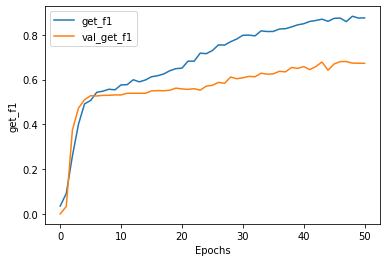

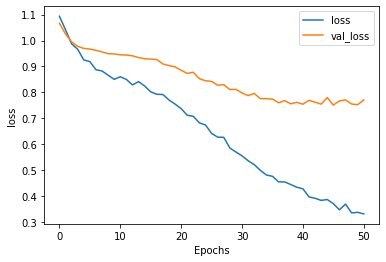

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/rnn/rnn_sp.h5")

In [ ]:

a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/rnn/rnn_sp.h5",  custom_objects={"get_f1": get_f1})

In [ ]:
p = model.predict(X_test)

15/15 [==============================] - 0s 2ms/step


In [ ]:
print(classification_report(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))

              precision    recall  f1-score   support

           0       0.59      0.53      0.56       130
           1       1.00      0.03      0.06        35
           2       0.77      0.89      0.83       302

    accuracy                           0.73       467
   macro avg       0.79      0.48      0.48       467
weighted avg       0.74      0.73      0.70       467



In [ ]:
print('accuracy')
print(accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))
print('f1 score')
print(f1_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('recall')
print(recall_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('precision')
print(precision_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))


accuracy
0.728051391862955
f1 score
0.6959185719469811
recall
0.728051391862955
precision
0.7393983185831374


#### LSTM


The first layer is the embedded layer that uses 100 length vectors to represent each word.
SpatialDropout1D performs variational dropout in NLP models.
The next layer is the LSTM layer with 100 memory units.
The output layer must create 3 output values, one for each class.
Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.summary()



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 10, 100)           100000    
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 10, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_6 (Dense)             (None, 3)                 303       
                                                                 
Total params: 180,703
Trainable params: 180,703
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = k.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/lstm/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:
epochs = 100
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=callbacks_list)


Epoch 1/100
13/14 [==========================>...] - ETA: 0s - loss: 1.0912 - get_f1: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.08570, saving model to /content/drive/MyDrive/Colab Notebooks/MA/lstm/checkpoint_sp/
14/14 [==============================] - 7s 375ms/step - loss: 1.0911 - get_f1: 0.0000e+00 - val_loss: 1.0857 - val_get_f1: 0.0000e+00
Epoch 2/100
13/14 [==========================>...] - ETA: 0s - loss: 1.0764 - get_f1: 0.0000e+00
Epoch 2: val_loss improved from 1.08570 to 1.07289, saving model to /content/drive/MyDrive/Colab Notebooks/MA/lstm/checkpoint_sp/
14/14 [==============================] - 4s 294ms/step - loss: 1.0755 - get_f1: 0.0000e+00 - val_loss: 1.0729 - val_get_f1: 0.0000e+00
Epoch 3/100
13/14 [==========================>...] - ETA: 0s - loss: 1.0592 - get_f1: 0.0000e+00
Epoch 3: val_loss improved from 1.07289 to 1.05610, saving model to /content/drive/MyDrive/Colab Notebooks/MA/lstm/checkpoint_sp/
14/14 [==============================] - 4s 288ms/ste

Epoch 42: val_loss did not improve from 0.52517
16/16 [==============================] - 1s 58ms/step - loss: 0.3515 - get_f1: 0.8703 - val_loss: 0.5355 - val_get_f1: 0.7946
Epoch 42: early stopping

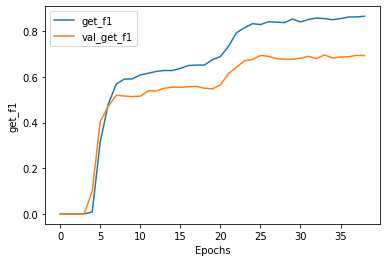

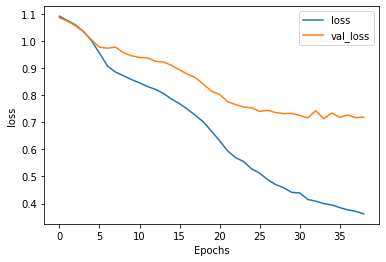

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/lstm/lstm_sp.h5")

In [ ]:

a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/lstm/lstm_sp.h5",  custom_objects={"get_f1": get_f1})

In [ ]:
p = model.predict(X_test)

15/15 [==============================] - 0s 4ms/step


In [ ]:
print(classification_report(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))

              precision    recall  f1-score   support

           0       0.58      0.65      0.61       130
           1       0.00      0.00      0.00        35
           2       0.81      0.87      0.84       302

    accuracy                           0.74       467
   macro avg       0.46      0.50      0.48       467
weighted avg       0.69      0.74      0.71       467



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy')
print(accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))
print('f1 score')
print(f1_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('recall')
print(recall_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('precision')
print(precision_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))


accuracy
0.7408993576017131
f1 score
0.7128583066318636
recall
0.7408993576017131
precision
0.6869363546162294


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Bi-LSTM


The first layer is the embedded layer that uses 100 length vectors to represent each word.
SpatialDropout1D performs variational dropout in NLP models.
The next layer is the LSTM layer with 100 memory units.
The output layer must create 3 output values, one for each class.
Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))
model.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 10, 100)           100000    
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 10, 100)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 3)                 603       
                                                                 
Total params: 261,403
Trainable params: 261,403
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = k.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/bilstm/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:
epochs = 100
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=callbacks_list)


Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.0923 - get_f1: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.08124, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bilstm/checkpoint_sp/
14/14 [==============================] - 16s 808ms/step - loss: 1.0923 - get_f1: 0.0000e+00 - val_loss: 1.0812 - val_get_f1: 0.0000e+00
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 1.0699 - get_f1: 0.0000e+00
Epoch 2: val_loss improved from 1.08124 to 1.06135, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bilstm/checkpoint_sp/
14/14 [==============================] - 11s 806ms/step - loss: 1.0699 - get_f1: 0.0000e+00 - val_loss: 1.0614 - val_get_f1: 0.0000e+00
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 1.0450 - get_f1: 0.0000e+00
Epoch 3: val_loss improved from 1.06135 to 1.03931, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bilstm/checkpoint_sp/
14/14 [==============================] - 10s 

Epoch 26: val_loss did not improve from 0.61862
16/16 [==============================] - 2s 126ms/step - loss: 0.3744 - get_f1: 0.8567 - val_loss: 0.6383 - val_get_f1: 0.7855
Epoch 26: early stopping

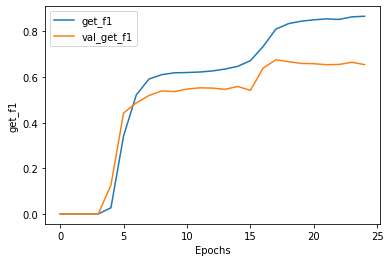

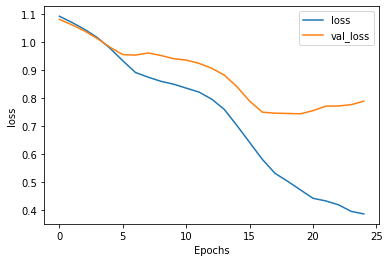

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/bilstm/bilstm_sp.h5")

In [ ]:

a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/bilstm/bilstm_sp.h5",  custom_objects={"get_f1": get_f1})

In [ ]:
p = model.predict(X_test)

15/15 [==============================] - 1s 7ms/step


In [ ]:
print(classification_report(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))

              precision    recall  f1-score   support

           0       0.59      0.70      0.64       130
           1       0.00      0.00      0.00        35
           2       0.82      0.85      0.83       302

    accuracy                           0.74       467
   macro avg       0.47      0.52      0.49       467
weighted avg       0.69      0.74      0.72       467



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy')
print(accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))
print('f1 score')
print(f1_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('recall')
print(recall_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('precision')
print(precision_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))


accuracy
0.7430406852248393
f1 score
0.7170196204542981
recall
0.7430406852248393
precision
0.69404165404718


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### GRU


The first layer is the embedded layer that uses 100 length vectors to represent each word.
SpatialDropout1D performs variational dropout in NLP models.
The next layer is the LSTM layer with 100 memory units.
The output layer must create 3 output values, one for each class.
Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.summary()



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 10, 100)           100000    
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 10, 100)          0         
 lDropout1D)                                                     
                                                                 
 gru_2 (GRU)                 (None, 100)               60600     
                                                                 
 dense_8 (Dense)             (None, 3)                 303       
                                                                 
Total params: 160,903
Trainable params: 160,903
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = k.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/gru/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:
epochs = 100
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=callbacks_list)


Epoch 1/100
13/14 [==========================>...] - ETA: 0s - loss: 1.0950 - get_f1: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.08794, saving model to /content/drive/MyDrive/Colab Notebooks/MA/gru/checkpoint_sp/
14/14 [==============================] - 7s 337ms/step - loss: 1.0947 - get_f1: 0.0000e+00 - val_loss: 1.0879 - val_get_f1: 0.0000e+00
Epoch 2/100
13/14 [==========================>...] - ETA: 0s - loss: 1.0786 - get_f1: 0.0000e+00
Epoch 2: val_loss improved from 1.08794 to 1.07469, saving model to /content/drive/MyDrive/Colab Notebooks/MA/gru/checkpoint_sp/
14/14 [==============================] - 4s 310ms/step - loss: 1.0783 - get_f1: 0.0000e+00 - val_loss: 1.0747 - val_get_f1: 0.0000e+00
Epoch 3/100
13/14 [==========================>...] - ETA: 0s - loss: 1.0624 - get_f1: 0.0000e+00
Epoch 3: val_loss improved from 1.07469 to 1.05964, saving model to /content/drive/MyDrive/Colab Notebooks/MA/gru/checkpoint_sp/
14/14 [==============================] - 5s 379ms/step -

Epoch 26: val_loss did not improve from 0.61862
16/16 [==============================] - 2s 126ms/step - loss: 0.3744 - get_f1: 0.8567 - val_loss: 0.6383 - val_get_f1: 0.7855
Epoch 26: early stopping

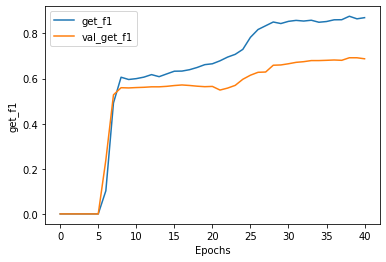

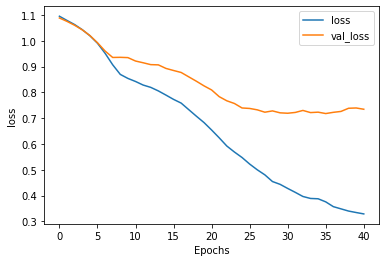

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/gru/gru_sp.h5")

In [ ]:

a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/gru/gru_sp.h5",  custom_objects={"get_f1": get_f1})

In [ ]:
p = model.predict(X_test)

15/15 [==============================] - 0s 4ms/step


In [ ]:
print(classification_report(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))

              precision    recall  f1-score   support

           0       0.57      0.64      0.60       130
           1       0.00      0.00      0.00        35
           2       0.80      0.85      0.83       302

    accuracy                           0.73       467
   macro avg       0.46      0.50      0.48       467
weighted avg       0.68      0.73      0.70       467



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy')
print(accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))
print('f1 score')
print(f1_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('recall')
print(recall_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('precision')
print(precision_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))


accuracy
0.7301927194860813
f1 score
0.7027912130695857
recall
0.7301927194860813
precision
0.6774923948243071


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Bi-GRU


The first layer is the embedded layer that uses 100 length vectors to represent each word.
SpatialDropout1D performs variational dropout in NLP models.
The next layer is the LSTM layer with 100 memory units.
The output layer must create 3 output values, one for each class.
Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))
model.summary()



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 10, 100)           100000    
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 10, 100)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              121200    
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 3)                 603       
                                                                 
Total params: 221,803
Trainable params: 221,803
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = k.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/bigru/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:
epochs = 100
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=callbacks_list)


Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.0949 - get_f1: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.08378, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bigru/checkpoint_sp/
14/14 [==============================] - 16s 858ms/step - loss: 1.0949 - get_f1: 0.0000e+00 - val_loss: 1.0838 - val_get_f1: 0.0000e+00
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 1.0694 - get_f1: 0.0000e+00
Epoch 2: val_loss improved from 1.08378 to 1.06094, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bigru/checkpoint_sp/
14/14 [==============================] - 12s 891ms/step - loss: 1.0694 - get_f1: 0.0000e+00 - val_loss: 1.0609 - val_get_f1: 0.0000e+00
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 1.0420 - get_f1: 0.0000e+00
Epoch 3: val_loss improved from 1.06094 to 1.03831, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bigru/checkpoint_sp/
14/14 [==============================] - 12s 919

Epoch 26: val_loss did not improve from 0.61862
16/16 [==============================] - 2s 126ms/step - loss: 0.3744 - get_f1: 0.8567 - val_loss: 0.6383 - val_get_f1: 0.7855
Epoch 26: early stopping

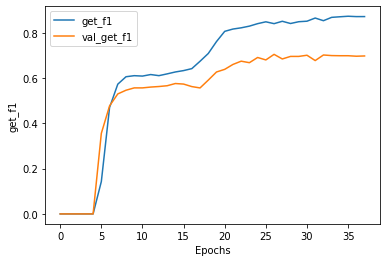

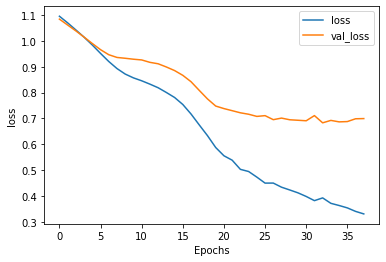

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/bigru/bigru_sp.h5")

In [ ]:

a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/bigru/bigru_sp.h5",  custom_objects={"get_f1": get_f1})

In [ ]:
p = model.predict(X_test)

15/15 [==============================] - 1s 7ms/step


In [ ]:
print(classification_report(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61       130
           1       0.00      0.00      0.00        35
           2       0.80      0.88      0.84       302

    accuracy                           0.74       467
   macro avg       0.47      0.50      0.48       467
weighted avg       0.68      0.74      0.71       467



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('accuracy')
print(accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1)))
print('f1 score')
print(f1_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('recall')
print(recall_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))
print('precision')
print(precision_score(np.argmax(Y_test, axis=-1), np.argmax(p, axis=-1),average='weighted'))


accuracy
0.7408993576017131
f1 score
0.7109900043144997
recall
0.7408993576017131
precision
0.6835309377508031


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Transfomers

#### Bert

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
train = train_sp[['coc','SP']]
test = test_sp[['coc','SP']]



In [ ]:
#train 

train.loc[train['SP'] == 'positive', 'SP'] = 1
train.loc[train['SP'] == 'negative', 'SP'] = -1
train.loc[train['SP'] == 'neutral', 'SP'] = 0
train = train[['coc','SP']]

train = train.astype({'SP':'int'})

#test 
test.loc[test['SP'] == 'positive', 'SP'] = 1
test.loc[test['SP'] == 'negative', 'SP'] = -1
test.loc[test['SP'] == 'neutral', 'SP'] = 0
test = test[['coc','SP']]

test = test.astype({'SP':'int'})

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [ ]:
X_train = train.coc
y_train = train.SP
X_test = test.coc
y_test = test.SP

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
X_input_ids = np.zeros((len(X_train), 256))
X_attn_masks = np.zeros((len(X_train), 256))

In [ ]:
X_input_ids_test = np.zeros((len(X_test), 256))
X_attn_masks_test = np.zeros((len(X_test), 256))

In [ ]:
def preprocessing_dataset(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df)):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
X_input_ids, X_attn_masks = preprocessing_dataset(X_train, X_input_ids, X_attn_masks, tokenizer)
#test
X_input_ids_test, X_attn_masks_test = preprocessing_dataset(X_test, X_input_ids_test, X_attn_masks_test, tokenizer)

1088it [00:00, 2480.60it/s]
467it [00:00, 2899.85it/s]


In [ ]:
labels = np.zeros((len(X_train), 3))
labels.shape

(1088, 3)

In [ ]:
labels_test = np.zeros((len(X_test), 3))
labels_test.shape

(467, 3)

In [ ]:
labels = pd.get_dummies(y_train).values
print('Shape of label tensor:', labels.shape)

Shape of label tensor: (1088, 3)


In [ ]:
labels_test = pd.get_dummies(y_test).values
print('Shape of label tensor:', labels_test.shape)

Shape of label tensor: (467, 3)


In [ ]:
labels_test

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [ ]:

dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
len(X_input_ids)

1088

In [ ]:
dataset_test = tf.data.Dataset.from_tensor_slices((X_input_ids_test, X_attn_masks_test, labels_test))
dataset_test.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
len(dataset)

1088

In [ ]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
dataset = dataset.map(SentimentDatasetMapFunction) 

In [ ]:
#test
dataset_test = dataset_test.map(SentimentDatasetMapFunction) 

In [ ]:
len(dataset_test)

467

In [ ]:
dataset_test

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset_test.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(3,), dtype=tf.uint8, name=None))>

In [ ]:
dataset = dataset.shuffle(10000).batch(1, drop_remainder=True)
#test
dataset_test = dataset_test.shuffle(10000).batch(1, drop_remainder=True)

In [ ]:
len(dataset_test)

467

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
dataset_test.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
p = np.round_(0.8 * len(dataset))
p
#train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

870.0

In [ ]:
#int((len(df)//16)*p)

In [ ]:
training_dataset = dataset.take(p)
validation_dataset = dataset.skip(p)
#training_dataset = dataset.take(len(dataset))

In [ ]:
len(training_dataset)

870

In [ ]:
len(validation_dataset)

218

In [ ]:
training_dataset

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(1, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(1, 3), dtype=tf.uint8, name=None))>

In [ ]:
#test
testing_dataset = dataset_test.take(len(dataset_test))


In [ ]:
len(testing_dataset)

467

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased') 

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] 

#intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)

embedding = tf.keras.layers.Dropout(0.5)(bert_embds) ##
output_layer = tf.keras.layers.Dense(3, activation='sigmoid', name='output_layer')(embedding)


sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)


sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.000006) #0.000005 try w other learning rate
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [ ]:


sentiment_model.compile(optimizer=optim, loss="categorical_crossentropy", metrics=[acc],)

In [ ]:
epochs = 100
batch_size = 64

history = sentiment_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    batch_size = batch_size,
    epochs=100,
    callbacks = callbacks_list
)

Epoch 1/100
870/870 [==============================] - ETA: 0s - loss: 0.9803 - accuracy: 0.5931
Epoch 1: val_loss improved from inf to 0.56837, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 122s 129ms/step - loss: 0.9803 - accuracy: 0.5931 - val_loss: 0.5684 - val_accuracy: 0.7844
Epoch 2/100
870/870 [==============================] - ETA: 0s - loss: 0.6073 - accuracy: 0.7690
Epoch 2: val_loss improved from 0.56837 to 0.47952, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 107s 123ms/step - loss: 0.6073 - accuracy: 0.7690 - val_loss: 0.4795 - val_accuracy: 0.8119
Epoch 3/100
870/870 [==============================] - ETA: 0s - loss: 0.4827 - accuracy: 0.8184
Epoch 3: val_loss improved from 0.47952 to 0.24142, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 107s 123ms/step - loss: 0.4827 - accuracy: 0.8184 - val_loss: 0.2414 - val_accuracy: 0.9312
Epoch 4/100
870/870 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8805
Epoch 4: val_loss improved from 0.24142 to 0.17744, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 106s 122ms/step - loss: 0.3416 - accuracy: 0.8805 - val_loss: 0.1774 - val_accuracy: 0.9266
Epoch 5/100
870/870 [==============================] - ETA: 0s - loss: 0.2857 - accuracy: 0.8920
Epoch 5: val_loss improved from 0.17744 to 0.14297, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 107s 123ms/step - loss: 0.2857 - accuracy: 0.8920 - val_loss: 0.1430 - val_accuracy: 0.9541
Epoch 6/100
870/870 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.9253
Epoch 6: val_loss improved from 0.14297 to 0.09855, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 106s 122ms/step - loss: 0.2181 - accuracy: 0.9253 - val_loss: 0.0985 - val_accuracy: 0.9679
Epoch 7/100
870/870 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.9494
Epoch 7: val_loss improved from 0.09855 to 0.03045, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint_sp/


870/870 [==============================] - 107s 122ms/step - loss: 0.1584 - accuracy: 0.9494 - val_loss: 0.0304 - val_accuracy: 0.9908
Epoch 8/100
870/870 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.9552
Epoch 8: val_loss did not improve from 0.03045
870/870 [==============================] - 74s 85ms/step - loss: 0.1237 - accuracy: 0.9552 - val_loss: 0.0486 - val_accuracy: 0.9817
Epoch 9/100
870/870 [==============================] - ETA: 0s - loss: 0.0908 - accuracy: 0.9678
Epoch 9: val_loss did not improve from 0.03045
870/870 [==============================] - 73s 84ms/step - loss: 0.0908 - accuracy: 0.9678 - val_loss: 0.0690 - val_accuracy: 0.9725
Epoch 10/100
870/870 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9690Restoring model weights from the end of the best epoch: 7.

Epoch 10: val_loss did not improve from 0.03045
870/870 [==============================] - 73s 84ms/step - loss: 0.1115 - accuracy: 0.9690 - val_loss: 0.0

In [ ]:
sentiment_model.save("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_sp.h5")

In [ ]:
#a = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_sp.h5",  custom_objects={"TFBertModel": TFBertModel})

In [ ]:
 a =sentiment_model.predict(testing_dataset)

467/467 [==============================] - 11s 19ms/step


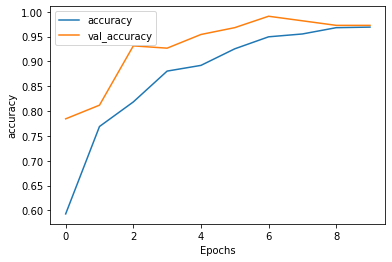

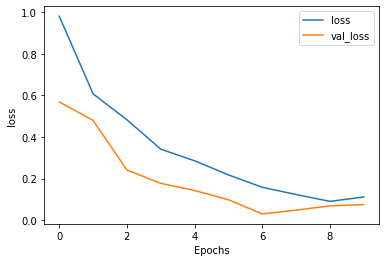

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
arg = np.argmax(a,axis=1)

In [ ]:
y_true = y_test.values

new_y_true = []

for y in y_true:
    new_y_true.append(y+1)

print(new_y_true)

[2, 0, 0, 1, 1, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 

In [ ]:
len(y_true)

467

In [ ]:
print(classification_report(new_y_true, arg))

              precision    recall  f1-score   support

           0       0.25      0.23      0.24       130
           1       0.07      0.06      0.06        35
           2       0.64      0.68      0.66       302

    accuracy                           0.51       467
   macro avg       0.32      0.32      0.32       467
weighted avg       0.49      0.51      0.50       467

